# Change Point Detection

## Problem statement

**Change Point Detection** (CPD) aims at identifying distribution shifts in the underlying time series data. Compared to Anomaly Detection, CPD does not deal with point anomalies, but separates data into long-term distribution modes.

A commot assumption: **AMOC** (At-Most One Change).
Let $X^{1:T} = \{X_{1},\ldots, X_{T}\},\ 1\leq T \leq \infty,\ X_{t}\in \mathbb{R}^{d}$ be a random sequence dependent on a latent random variable $\theta\sim\mathbb{G}$ If $t<\theta\colon X_{t}\sim f_{\infty}$ — "normal" behavior of the process. If $t\geq \theta\colon X_{t}\sim f_{0}$ — the process is in the "abnormal" stage. Time moment $\theta\leq T$  is a Change Point. If $\theta = T$, then no CP occurres.

One can deal with time series with several CPs as well.

A couple of examples of simple CPs in 1D signals. Note: the last example contains an anomaly but not a CP.

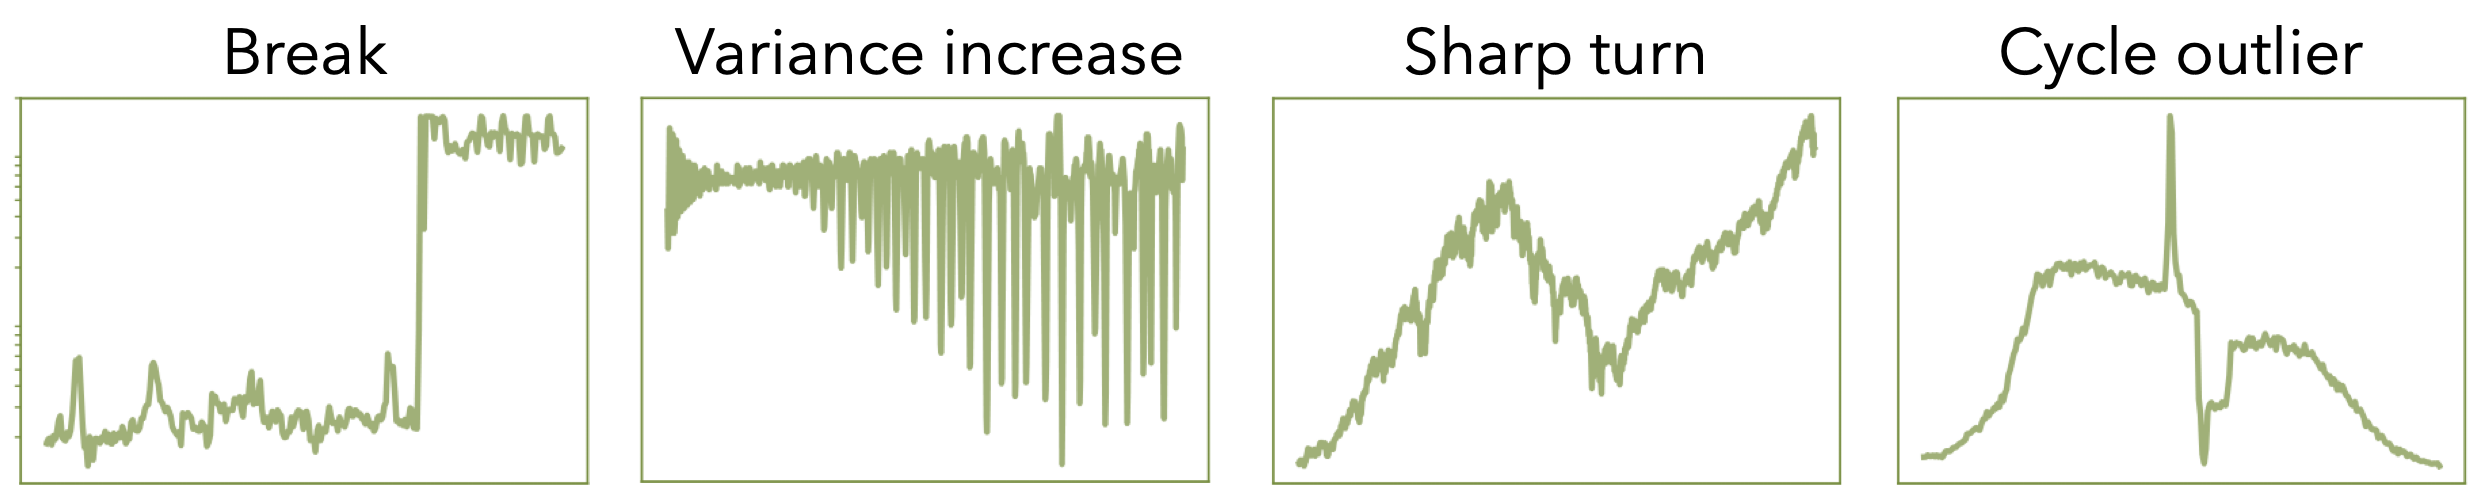

In [1]:
# install packages, donwload data

!pip install ruptures
!git clone https://github.com/stalex2902/cpd-seminar.git

%cd cpd-seminar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.6 MB/s eta 0:00:00
Cloning into 'cpd-seminar'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 243 (delta 42), reused 69 (delta 28), pack-reused 145
Receiving objects: 100% (243/243), 81.98 MiB | 21.07 MiB/s, done.
Resolving deltas: 100% (154/154), done.
Updating files: 100% (149/149), done.
/content/cpd-seminar


In [2]:
# all necessary imports
import numpy as np

import ruptures as rpt
from ruptures.metrics import precision_recall, hausdorff, randindex

import scipy.io as sio
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Part 1: simple data and 'ruptures' package

'Ruptures' is a useful python package for CPD with the implementation of basic untrainable CPD algorithms, e.g. binary segmentation, bottom-up segmentation, PELT, kernel CPD, etc.

In this seminar, we'll consider several illustrative cases of its usage. See the [manual](https://centre-borelli.github.io/ruptures-docs/) for the documentation and the gallery of examples.

### Synthetic data

Ruptures allow to generate simple multivariate synthetic data: piesewise-constant and piecewise-linear signals with noise, piecewise normal and piecewise sinusoidal. Let's have generate simple 1D piecewise-constant time series with 5 CPs.

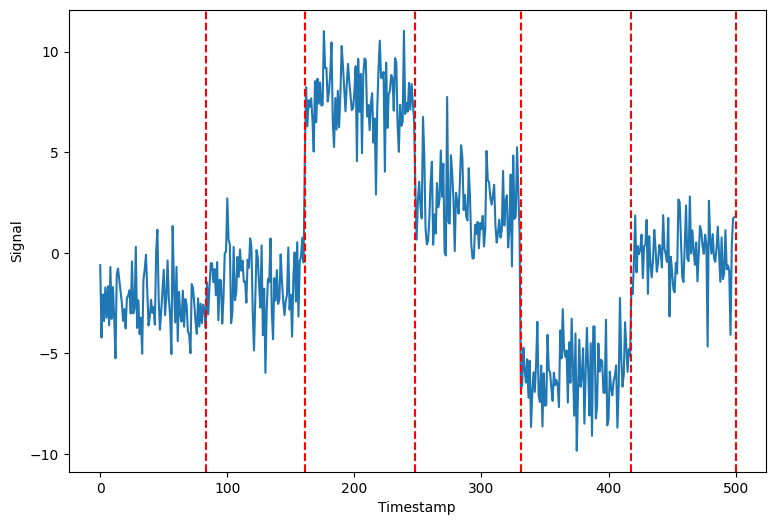

In [3]:
n_samples, n_dims, sigma = 500, 1, 1.5
n_cps = 5  # number of change points
signal, cps = rpt.pw_constant(n_samples, n_dims, n_cps, noise_std=sigma)

plt.figure(figsize=(9, 6))
plt.plot(signal)
for cp in cps:
    plt.axvline(cp, c="red", linestyle="--")
plt.xlabel("Timestamp")
plt.ylabel("Signal")
plt.show()

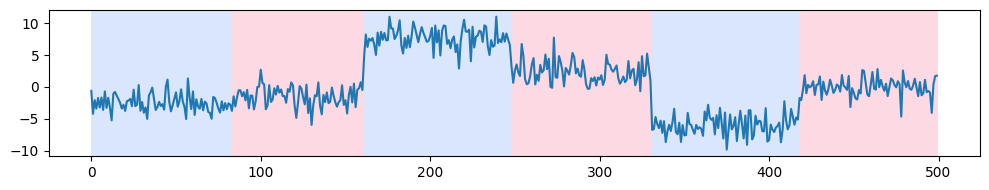

In [4]:
# built-in ruptures function for visualization
fig, ax_array = rpt.display(signal, cps)

### Simple models from ruptures

Considered models are basically basicaly targeted for detecting changes in mean of the underlying process. They successfully work with time series several CPs satisfying this structural assumption.


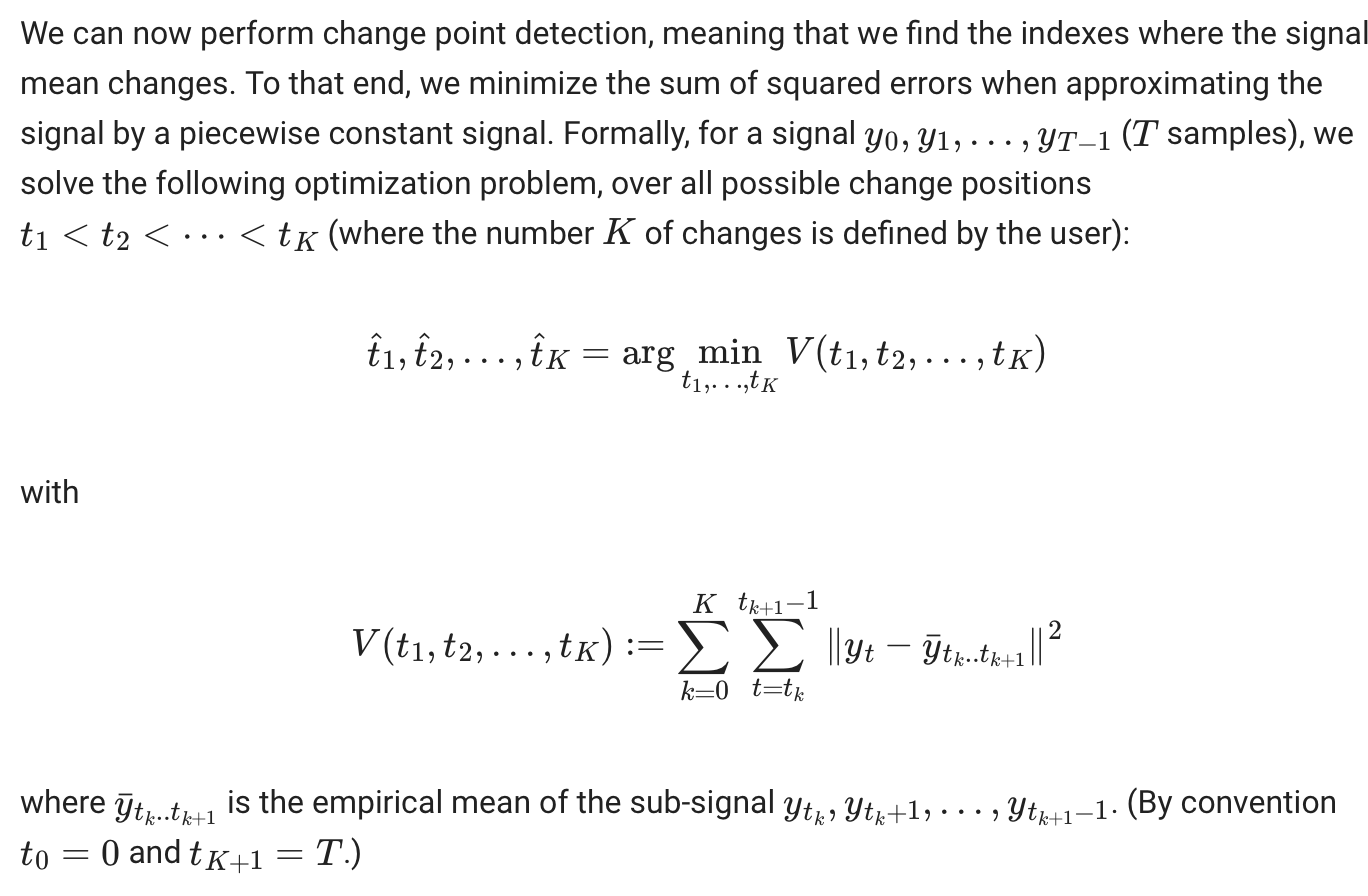

Main models are the following.

* Binary segmentation: splits initial task into a sequence of CPD tasks with AMOC assumption ([paper 1](http://www.columbia.edu/~jb3064/papers/1997_Estimating_multiple_breaks_one_at_a_time.pdf), [paper 2](https://arxiv.org/abs/1411.0858))
* Dynp: uses dynamic programming for optimization above (I suppose this is their own method)
* PELT: uses cost function with penalty (see [paper](https://www.researchgate.net/publication/48180788_Optimal_Detection_of_Changepoints_With_a_Linear_Computational_Cost))
* KernelCPD: maps signal into RKHS and performs CPD there (e.g. [paper 1](https://arxiv.org/abs/1710.04556) and [paper 2](https://arxiv.org/abs/1202.3878))

These methods may have different cost functions $V$. See more basic methods and their details in the [manual](https://centre-borelli.github.io/ruptures-docs/user-guide/).

CPs predicted by Binseg: [85, 160, 250, 330, 420, 500]


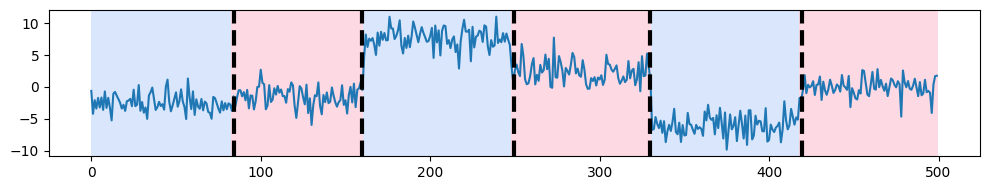

CPs predicted by Dynp: [85, 160, 250, 330, 420, 500]


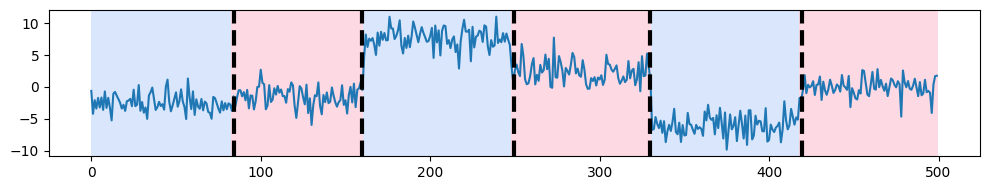

CPs predicted by PELT: [160, 250, 330, 420, 500]


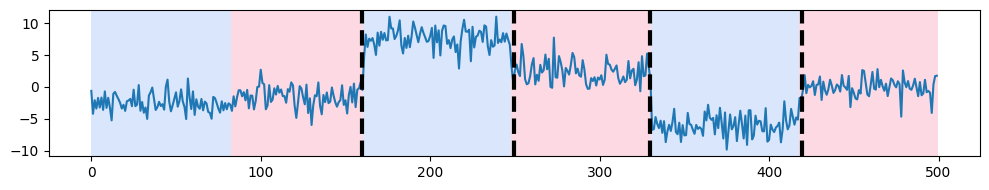

CPs predicted by KernelCPD: [86, 161, 248, 331, 418, 500]


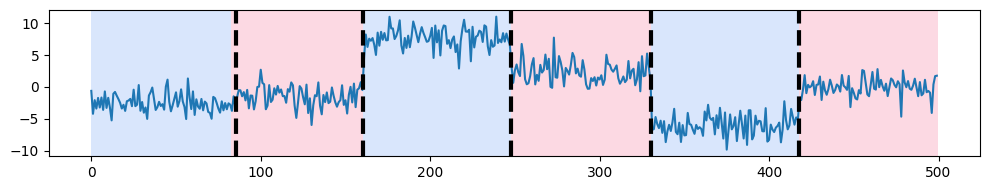

In [5]:
results_dict = dict()

algo = rpt.Binseg(model="l2").fit(signal)
result_binseg = algo.predict(n_bkps=n_cps)
results_dict["binseg"] = result_binseg

print("CPs predicted by Binseg:", result_binseg)

rpt.display(signal, cps, result_binseg)
plt.show()
# -----------------------------------------------#

algo = rpt.Dynp(model="l2").fit(signal)
result_dynp = algo.predict(n_bkps=n_cps)
results_dict["dynp"] = result_dynp

print("CPs predicted by Dynp:", result_dynp)

rpt.display(signal, cps, result_dynp)
plt.show()
# -----------------------------------------------#

algo = rpt.Pelt(model="l2").fit(signal)
result_pelt = algo.predict(pen=50)
results_dict["pelt"] = result_pelt

print("CPs predicted by PELT:", result_pelt)

rpt.display(signal, cps, result_pelt)
plt.show()
# -----------------------------------------------#

algo = rpt.KernelCPD(kernel="rbf").fit(signal)
result_kernel = algo.predict(n_bkps=n_cps)
results_dict["kernel"] = result_kernel

print("CPs predicted by KernelCPD:", result_kernel)

rpt.display(signal, cps, result_kernel)
plt.show()

### Evaluation metrics

1. **Classification-based** metrics (e.g. precision, recall, F1) with specific interpretation of Confusion Matrix elements. Let $\tau$ be the predicted CP and $\theta$ - the true one.
    - Option 1 (more common): detection is True Positive if $|\tau - \theta| < m$ for some margin $m$.
    - Option 2 (ours for AMOC): detection is True Positive, if $\tau \geq \theta$ and $\theta < T$ (i.e. change really occurres).

2. **Segmentation-based** metrics (e.g. Hausdorff metric, Rand index, Covering score, etc.) measure similarity of 2 partitionings of a time series: one made by the true CPs and one made by the predicted ones.

3. **Specific** CPD metrics (e.g. Detection Delay, Time for False Alarm, Area under the Detection Curve). DD is equal to $\tau - \theta$ for a TP prediction; Time to FA is equal to $tau$ for a FP prediction. See picture below.

In ruptures, there are metrics of groups 1 and 2. We'll have a look at the task-specific metrics later.

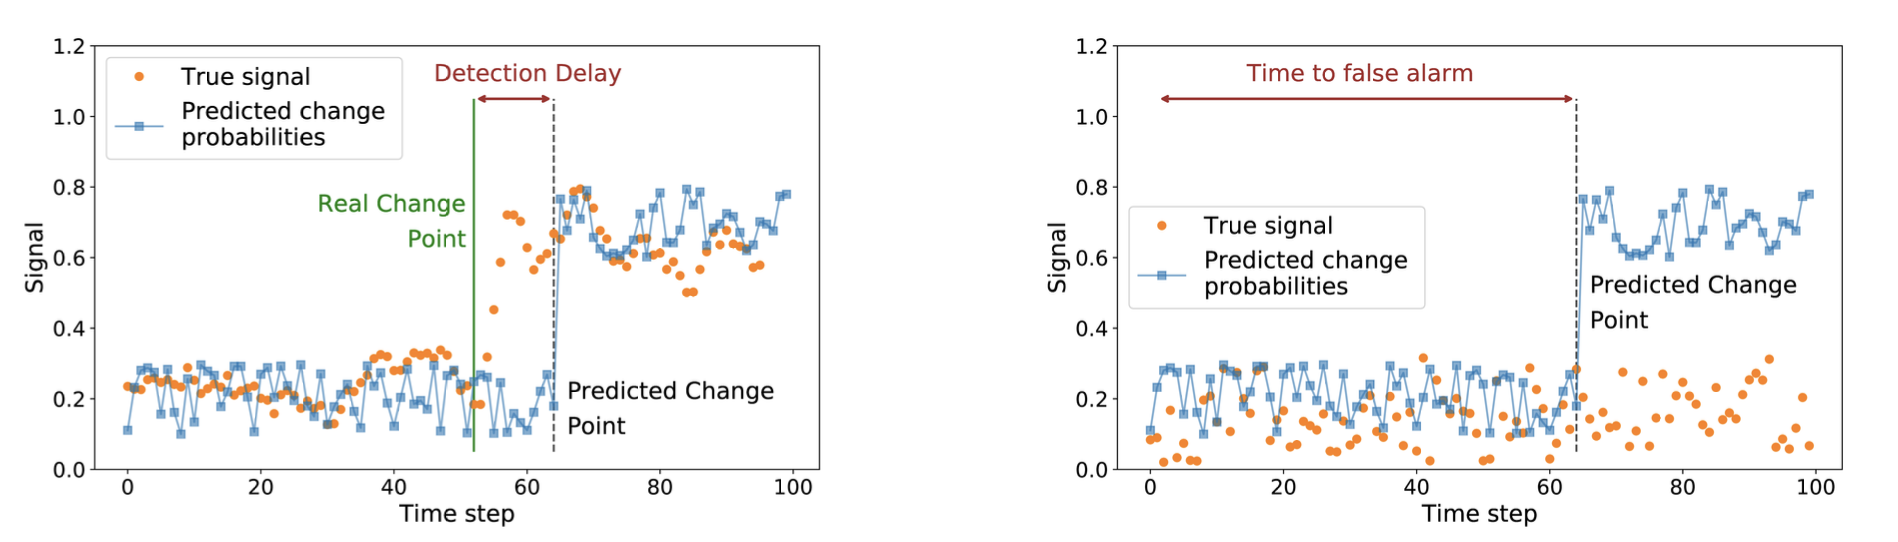

In [6]:
for model, preds in results_dict.items():
    pr, rec = precision_recall(cps, preds, margin=10) # margin = 10 by default
    haus = hausdorff(cps, preds) # should be small
    rand = randindex(cps, preds) # should be large but <= 1
    print(f"Model: {model}")
    print(f"prec = {np.round(pr, 2)}, rec = {np.round(rec, 2)}, hausdorff = {np.round(haus, 2)}, rand = {np.round(rand, 2)}")
    print("-" * 52)

Model: binseg
prec = 1.0, rec = 1.0, hausdorff = 2.0, rand = 0.99
----------------------------------------------------
Model: dynp
prec = 1.0, rec = 1.0, hausdorff = 2.0, rand = 0.99
----------------------------------------------------
Model: pelt
prec = 1.0, rec = 0.8, hausdorff = 77.0, rand = 0.94
----------------------------------------------------
Model: kernel
prec = 1.0, rec = 1.0, hausdorff = 3.0, rand = 1.0
----------------------------------------------------


We see that all the models perfectly solve this trivial CPD task. Let's have a look at

## Part 2: real 3D data

'Beedance' records the pixel locations in x and y dimensions and angle differences of bee movements. Ethologists are interested in the three-stages bee waggle dance and aim at identifying the change point from one stage to another, where different stages serve as the communication with other honey bees about the location of pollen and water. See [link](https://sites.cc.gatech.edu/~borg/ijcv_psslds/) to the dataset.

For those interested in ethology, look in [wikipedia](https://en.wikipedia.org/wiki/Waggle_dance) for the description.

In [7]:
def load_data(data_path: str, dataset: str) -> tuple[np.array, list]:
    """Loads data from .mat format and prepares CPD labels."""
    data_raw = sio.loadmat(f"{data_path}/{dataset}.mat")

    data = data_raw['Y']
    target = data_raw['L']

    if dataset == "fishkiller":
        subseq_len = 5000
        data, target = data[:subseq_len], target[:subseq_len]

        cps = list(np.where(np.diff(target.flatten()) != 0)[0])

    elif dataset == "beedance":
        cps = list(np.where(target.flatten() != 0)[0])

    cps.append(len(target))
    return data, cps

In [8]:
data, cps = load_data(data_path="data", dataset="beedance")

print("Data shape   :", data.shape)
print("Num of change points:", len(cps))

Data shape   : (1057, 3)
Num of change points: 20


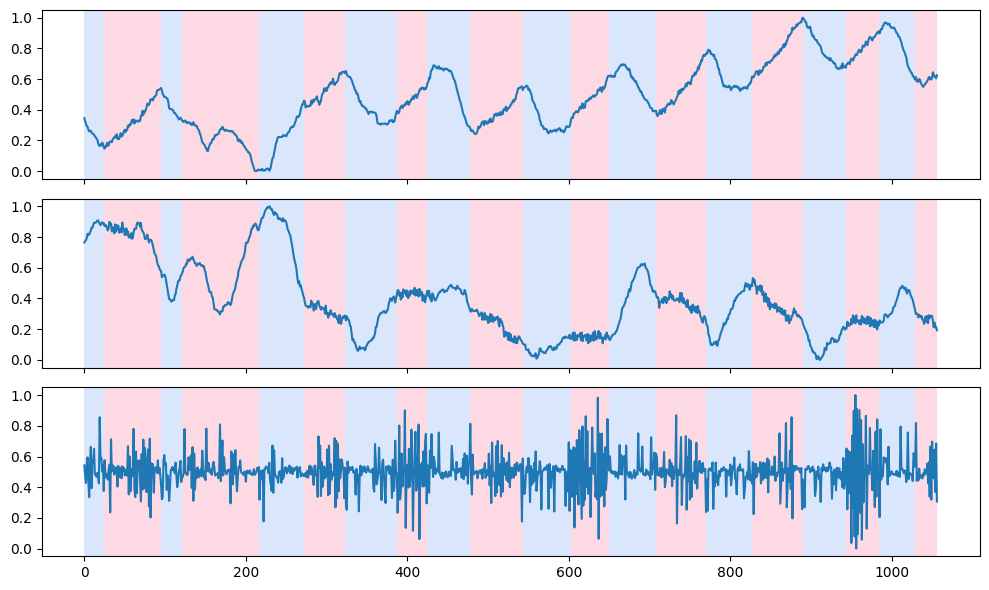

In [9]:
rpt.display(data, cps)
plt.show()

Let's use the same algorithms from ryptures for this time series as well.

CPs predicted by Binseg: [70, 90, 145, 200, 255, 270, 335, 360, 385, 470, 520, 630, 665, 700, 755, 800, 855, 970, 1010, 1025, 1057]


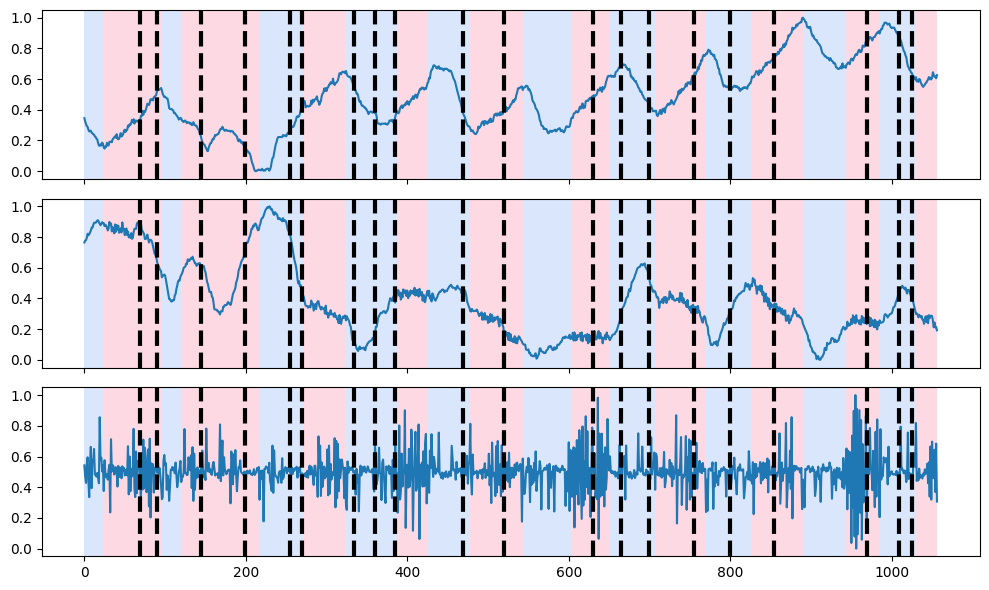

CPs predicted by Dynp: [85, 145, 195, 260, 295, 335, 365, 405, 470, 520, 560, 620, 670, 700, 750, 800, 855, 900, 955, 1020, 1057]


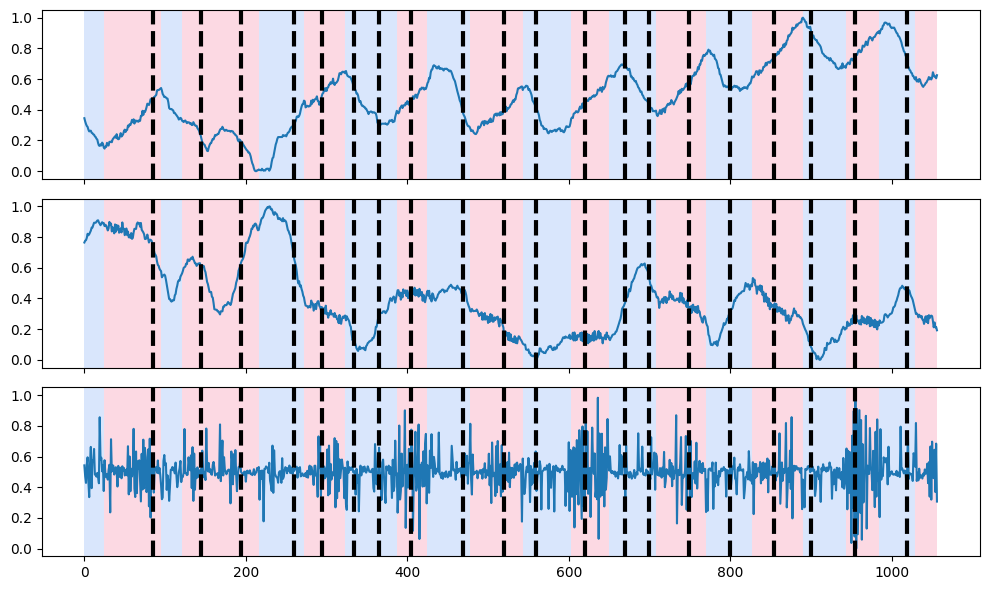

CPs predicted by PELT: [85, 145, 195, 260, 295, 335, 365, 405, 470, 520, 635, 670, 750, 800, 855, 900, 955, 1020, 1057]


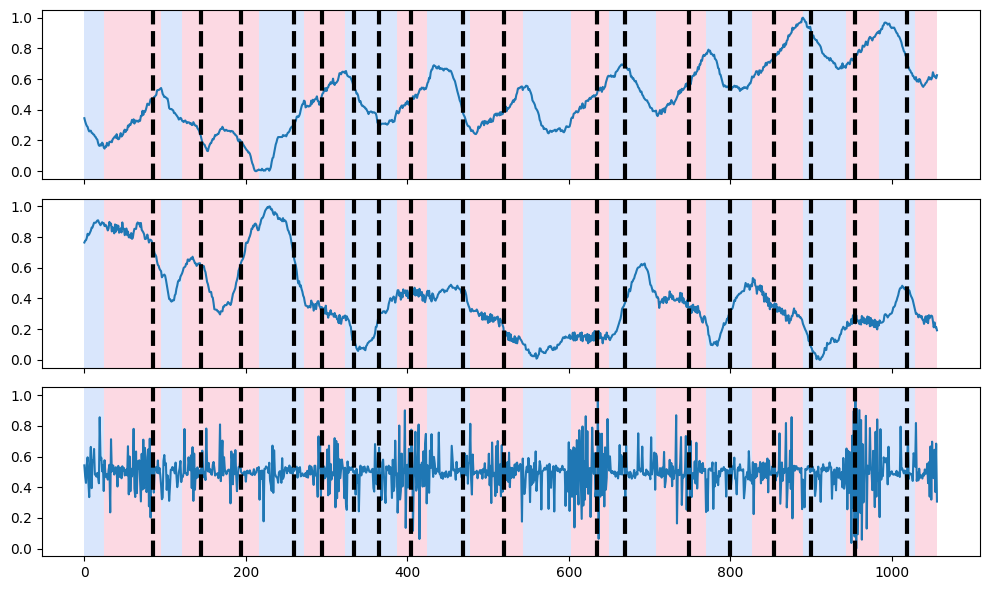

CPs predicted by KernelCPD: [84, 145, 197, 261, 295, 332, 363, 416, 467, 520, 562, 613, 666, 700, 752, 800, 858, 900, 950, 1019, 1057]


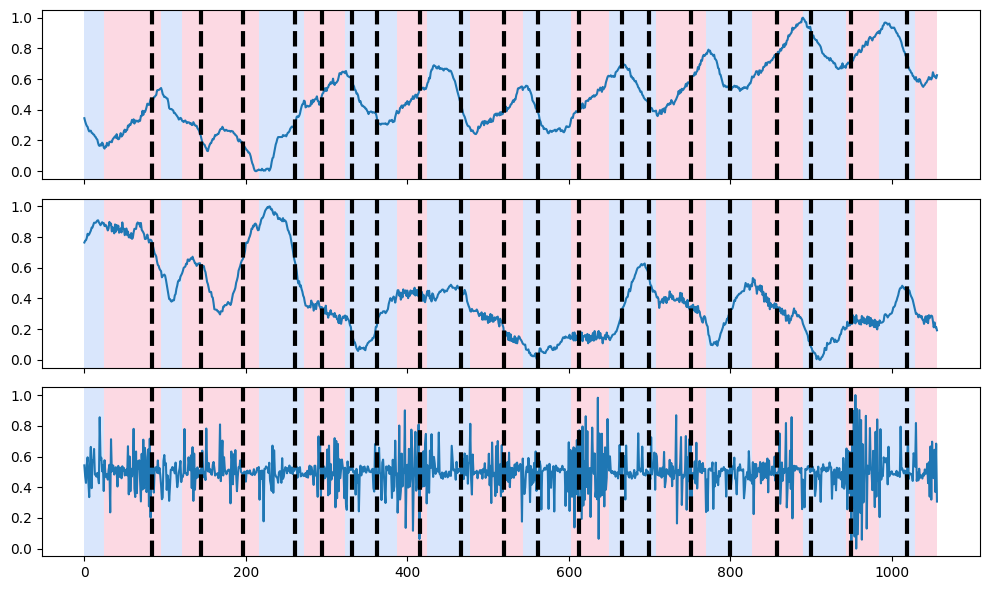

In [10]:
n_cps = len(cps)
results_dict = dict()

algo = rpt.Binseg(model="l2").fit(data)
result_binseg = algo.predict(n_bkps=n_cps)
results_dict["binseg"] = result_binseg

print("CPs predicted by Binseg:", result_binseg)

rpt.display(data, cps, result_binseg)
plt.show()
# -----------------------------------------------#

algo = rpt.Dynp(model="l2").fit(data)
result_dynp = algo.predict(n_bkps=n_cps)
results_dict["dynp"] = result_dynp

print("CPs predicted by Dynp:", result_dynp)

rpt.display(data, cps, result_dynp)
plt.show()
# -----------------------------------------------#

algo = rpt.Pelt(model="l2").fit(data)
result_pelt = algo.predict(pen=0.7)
results_dict["pelt"] = result_pelt

print("CPs predicted by PELT:", result_pelt)

rpt.display(data, cps, result_pelt)
plt.show()
# -----------------------------------------------#

algo = rpt.KernelCPD(kernel="rbf").fit(data)
result_kernel = algo.predict(n_bkps=n_cps)
results_dict["kernel"] = result_kernel

print("CPs predicted by KernelCPD:", result_kernel)

rpt.display(data, cps, result_kernel)
plt.show()

In [11]:
for model, preds in results_dict.items():
    pr, rec = precision_recall(cps, preds, margin=10)
    haus = hausdorff(cps, preds)
    rand = randindex(cps, preds)
    print(f"Model: {model}")
    print(f"prec = {np.round(pr, 2)}, rec = {np.round(rec, 2)}, hausdorff = {np.round(haus, 2)}, rand = {np.round(rand, 2)}")
    print("-" * 52)

Model: binseg
prec = 0.3, rec = 0.32, hausdorff = 45.0, rand = 0.95
----------------------------------------------------
Model: dynp
prec = 0.2, rec = 0.21, hausdorff = 60.0, rand = 0.96
----------------------------------------------------
Model: pelt
prec = 0.17, rec = 0.16, hausdorff = 60.0, rand = 0.95
----------------------------------------------------
Model: kernel
prec = 0.25, rec = 0.26, hausdorff = 59.0, rand = 0.96
----------------------------------------------------


### Optimal CPD: CUSUM-statistic

CUSUM is a statistic optimizing one of the principled CPD criterias (Lorden criteria, D-criteria):

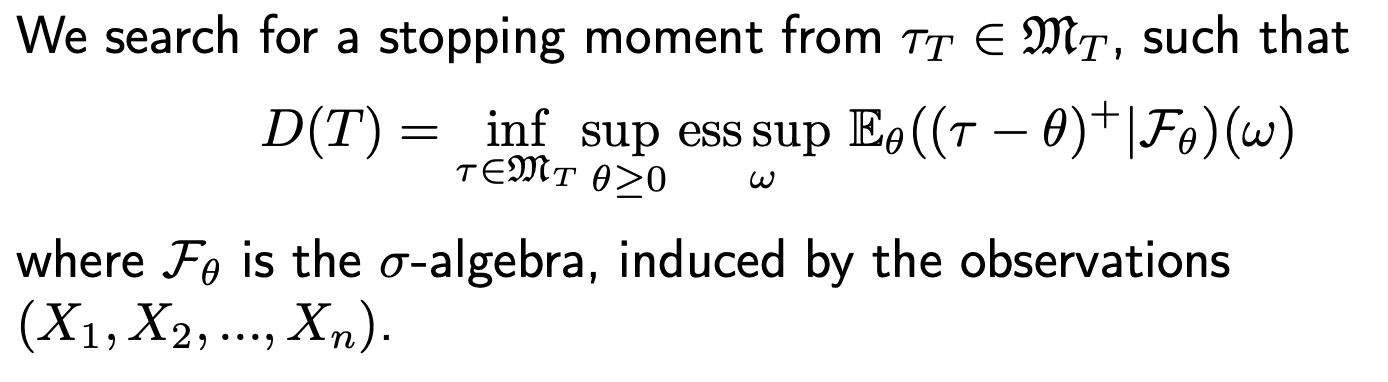

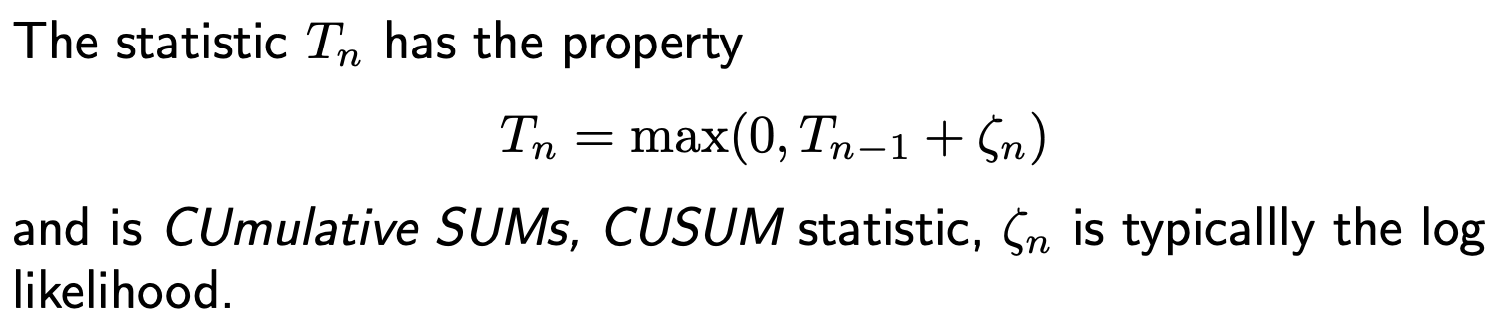



Use 1D 'fishkiller' data here.

**Fishkiller** records water level from a dam in Canada. When the dam not functions normally, the water level oscillates quickly in a particular pattern, causing trouble for the fish. The beginning and end of every water oscillation (fish kills) are treated as change points. See [repo](http://mldata.org/repository/data/viewslug/fish_killer/).

In [21]:
data, cps = load_data(data_path="data", dataset="fishkiller")

print("Data shape   :", data.shape)
print("Num of change points:", len(cps))

Data shape   : (5000, 1)
Num of change points: 11


In [22]:
def cusum_detector(series: np.array, threshold: float) -> list[int]:
    """Implements basic CUSUM CP detector for a series with changes in mean."""

    normal_to_change_stat, change_to_normal_stat  = np.zeros(len(series)), np.zeros(len(series))
    normal_to_change_ind, change_to_normal_ind  = [], []

    all_change_idxs = []
    for i in range(1, len(series)):
        t = series[i] - series[i - 1]
        normal_to_change_stat[i] = max(0, normal_to_change_stat[i - 1] + t)
        change_to_normal_stat[i] = max(0, change_to_normal_stat[i - 1] - t)

        if normal_to_change_stat[i] > threshold:
            normal_to_change_ind.append(i)
            all_change_idxs.append(i)
            normal_to_change_stat[i] = 0

        if change_to_normal_stat[i] > threshold:
            change_to_normal_ind.append(i)
            all_change_idxs.append(i)
            change_to_normal_stat[i] = 0

    all_change_idxs.append(len(series))

    return all_change_idxs

In [23]:
result_cusum = cusum_detector(data, 0.09)
result_cusum

[956, 2030, 2041, 2124, 2204, 2264, 3346, 4094, 4300, 4374, 4378, 5000]

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

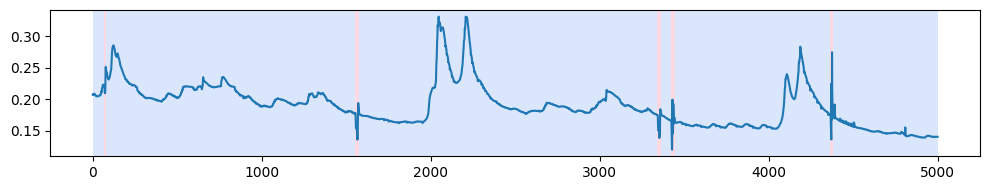

In [24]:
rpt.display(data, cps)

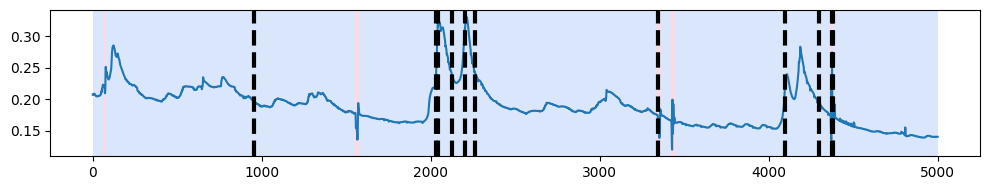

prec = 0.18, rec = 0.2, hausdorff = 888.0, rand = 0.84


In [25]:
rpt.display(data, cps, result_cusum)
plt.show()

pr, rec = precision_recall(cps, result_cusum, margin=100)
haus = hausdorff(cps, result_cusum)
rand = randindex(cps, result_cusum)

print(f"prec = {np.round(pr, 2)}, rec = {np.round(rec, 2)}, hausdorff = {np.round(haus, 2)}, rand = {np.round(rand, 2)}")

## Part 3: Neural CPD

As we have seen above, classical statistical procedures work well for simple low-dimensional structured data. In addition, some of them have nice optimality properties. However, they cannot process complex multidimensional data (e.g. videos). Here, neural (parametric) CPD models come handy.

One approach: to learn "good and effective" representations of time series and apply classification CPD procedures on top of them. This works.

Another approach: develop and train specific CPD models in an end-to-end manner. This works as well :)

In this seminar, we'll have a look at 2 CPD models:
1. simple but rather strong LSTM-based model with that looks at CPD from the binary classification perspective (supervised CPD)
2. TS-CP2 - CNN-based contrastive SSL model for CPD

In [3]:
!pip install pytorch_lightning
!pip install tsai # package needed to work with TS-CP2 model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.1/313.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.8 MB/s eta 0:00:00


In [4]:
import yaml

import torch
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from utils import datasets, metrics, core_models, cpd_models, tscp
from utils.visualize import visualize_predictions

In [5]:
SEED = 42
seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

### Human Activity Recognition dataset

USC-HAD [dataset](https://www.researchgate.net/publication/262291666_USC-HAD_a_daily_activity_dataset_for_ubiquitous_activity_recognition_using_wearable_sensors) is a dataset of numerical sequences  with 12 types of human activities.
We sample subsequences with changes in the type of human activity and without them.
Each subsequence consists of 28 selected measurements (different types of accelerometers, gyroscopes, etc.) during 20 time ticks.

This dataset satisfies AMOC assumption, and approximately 87% of sequences contain CPs.

In [6]:
experiments_name = "human_activity"
train_dataset, test_dataset = datasets.CPDDatasets(experiments_name=experiments_name).get_dataset_()

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

len(train_dataset), len(test_dataset)

(3580, 1337)

Let's look at a couple of examples of sequences from the dataset. We select only 3 first features ("tBodyAcc-Mean-1", "tBodyAcc-Mean-2", "tBodyAcc-Mean-3") for visualization.

[]

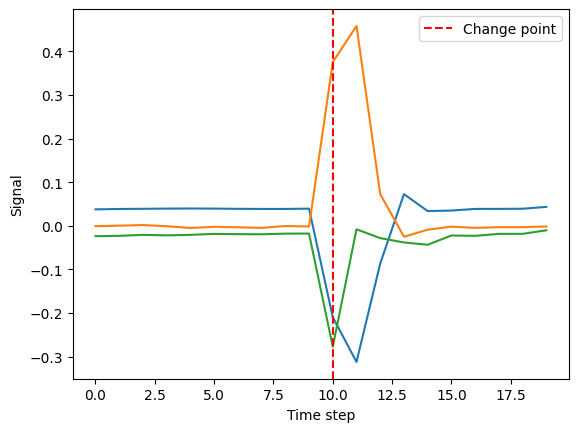

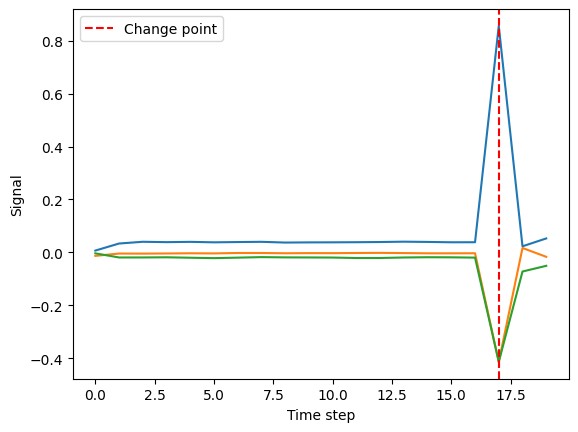

In [56]:
sequence, labels = train_dataset[1500]
cp = labels.argmax()
num_feat = 3

plt.figure()
plt.plot(sequence[:, :num_feat])
plt.axvline(cp, c="red", linestyle="--", label="Change point")
plt.xlabel("Time step")
plt.ylabel("Signal")
plt.legend()
plt.plot()

sequence, labels = train_dataset[3000]
cp = labels.argmax()

plt.figure()
plt.plot(sequence[:, :num_feat])
plt.axvline(cp, c="red", linestyle="--", label="Change point")
plt.xlabel("Time step")
plt.ylabel("Signal")
plt.legend()
plt.plot()

### Non-trainable baselines

First, let's try to solve this task by the methods we have already worked with before. For convinience, we'll use a custom wrapper of standard models from ruptures.

In [57]:
# best model for HAR is KernelCPD with 'rbf' kernel and pen=0.3
baseline_model = cpd_models.ClassicBaseline(rpt.KernelCPD(kernel="rbf"), pen=0.3)
baseline_metrics = metrics.calculate_baseline_metrics(baseline_model, test_dataloader, verbose=True, margin_list=[1, 2, 4, 6])
baseline_fp_delay, baseline_delay = baseline_metrics[1], baseline_metrics[2]

TN: 0, FP: 663, FN: 0, TP: 674
DELAY: 0.07, FP_DELAY:5.9
F1:0.6703
COVER: 0.8538
Max F1 with margin 1: 0.7107
Max F1 with margin 2: 0.7569
Max F1 with margin 4: 0.7711
Max F1 with margin 6: 0.7868


### BCE model

In AMOC assumption, we can look at CPD task as at a sequence-to-sequence binary classification task: for each time step $t$, we decide whether tha observation $X_t$ happend before or after a change points. Thus, we can train any model with seq2seq architecture with a standard binary cross-entropy (BCE) loss. As a result, this models predicts **change probabilities** at each time step.

The general schema of a seq2seq CPD model is presented below. The input sequence may have any (time-ordered) nature but not only video frames as in example:

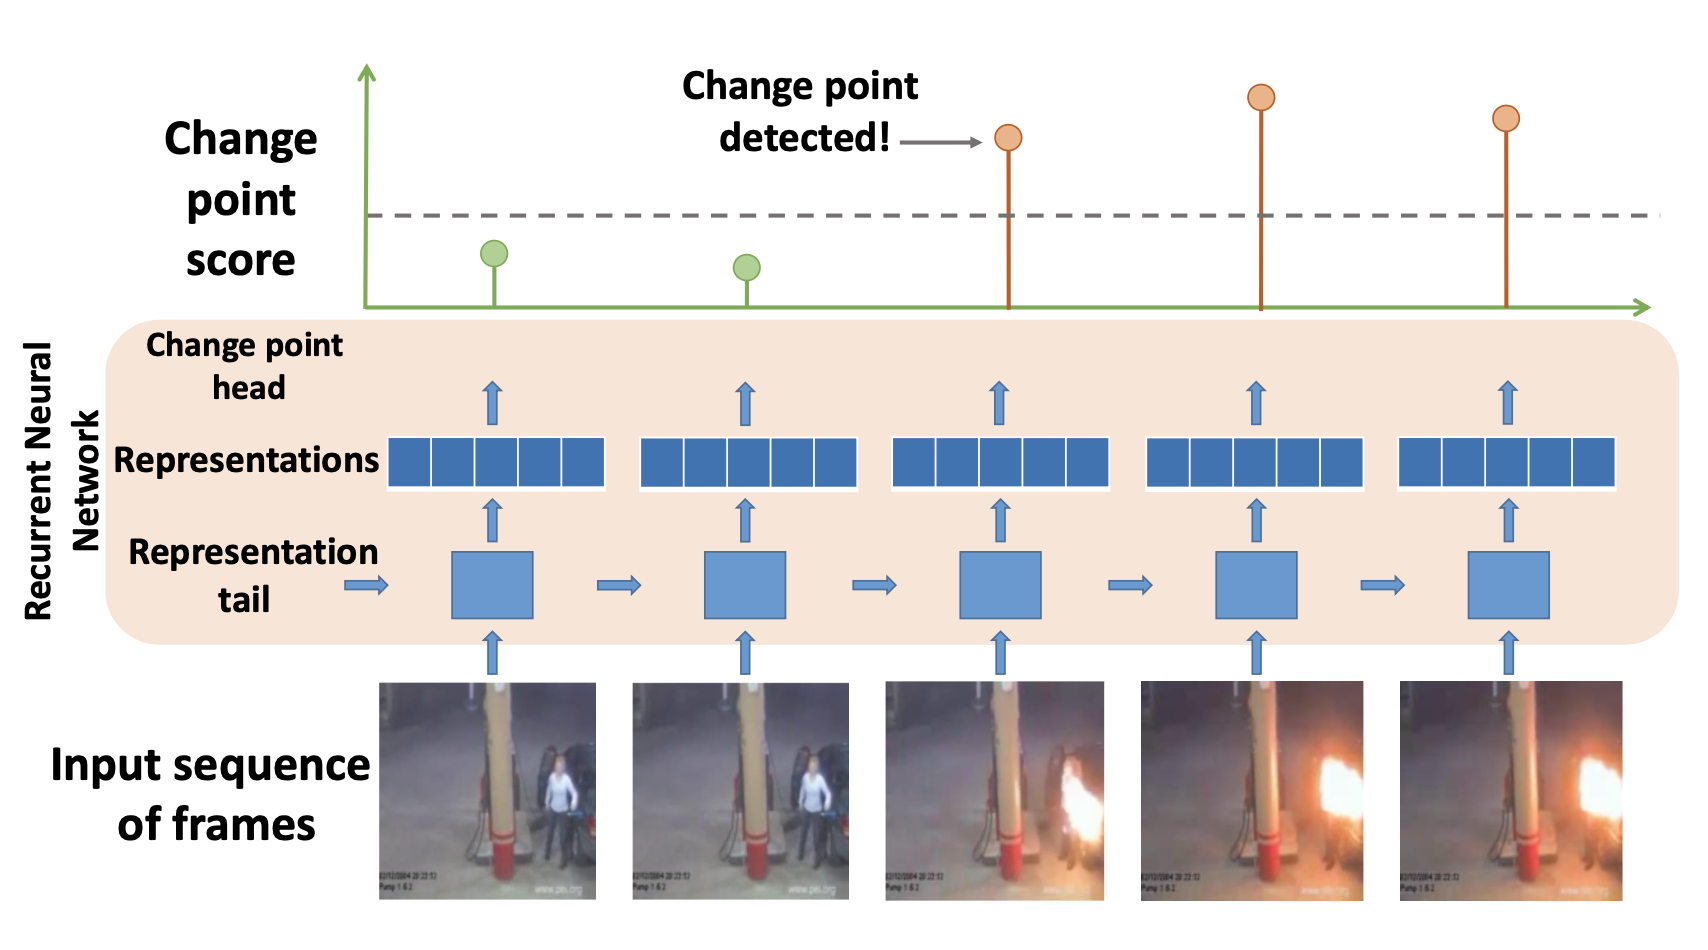

In [58]:
# read model parameters from config
model_type = "seq2seq"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config,'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 2

In [59]:
# initialize LSTM-based seq2seq model
core_model_bce = core_models.BaseRnn(**args_config["model"])

# define CPDModel with BCE loss
bce_model = cpd_models.CPDModel(
    loss_type="bce",
    args=args_config,
    model=core_model_bce,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)
bce_model

CPDModel(
  (model): BaseRnn(
    (lstm): LSTM(28, 8, num_layers=2, batch_first=True, dropout=0.5)
    (linear): Linear(in_features=8, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (loss): BCELoss()
)

Training does not take much time (5-7 min) but I've prepared a state dict of a trained model.

In [ ]:
'''
# use logger
logger = TensorBoardLogger(save_dir="logs/")

# define trainer with custom parameters
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    callbacks=EarlyStopping(**args_config["early_stopping"]) # use early stopping
)
trainer.fit(bce_model)

torch.save(bce_model.state_dict(), "saved_models/bce_har_default.pth")
'''

In [60]:
bce_model.load_state_dict(torch.load("saved_models/bce_har_default.pth"))

<All keys matched successfully>

Let's visualize the predicted change probabilities for a batch of test sequences. As we see, they look pretty much perfect.

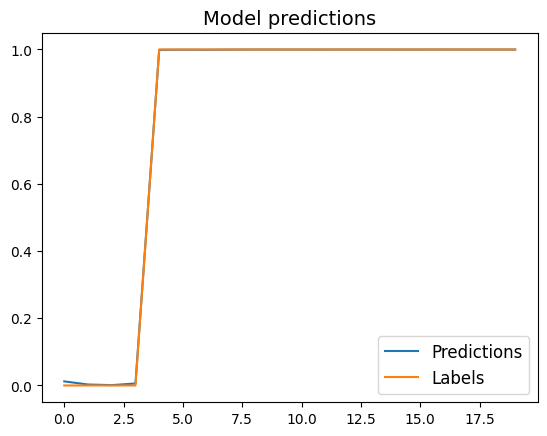

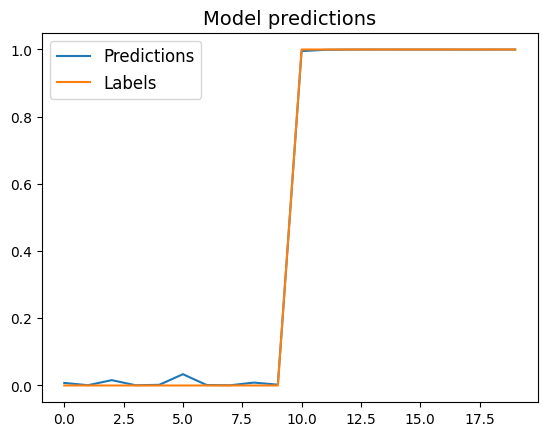

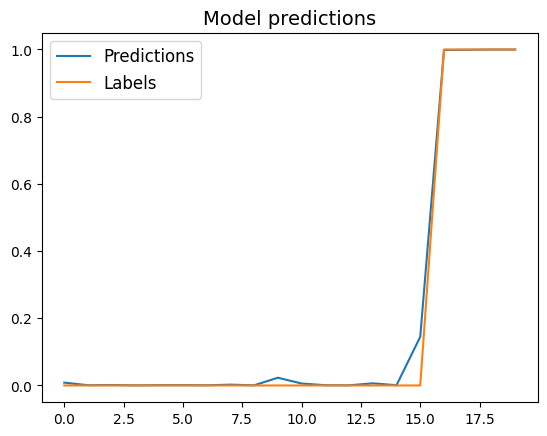

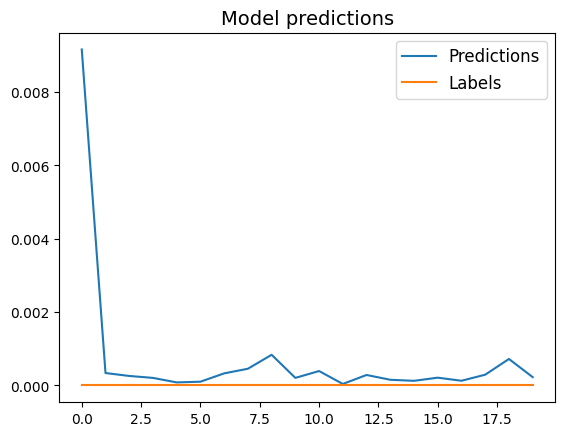

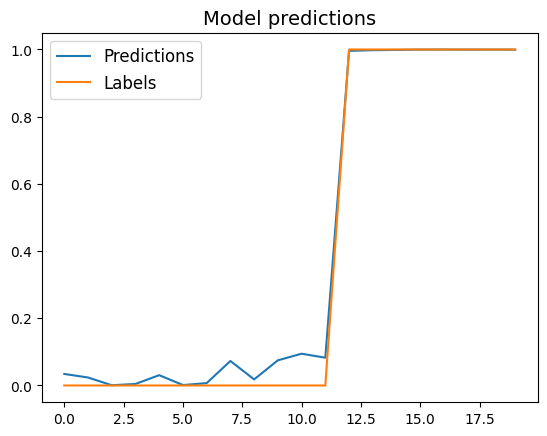

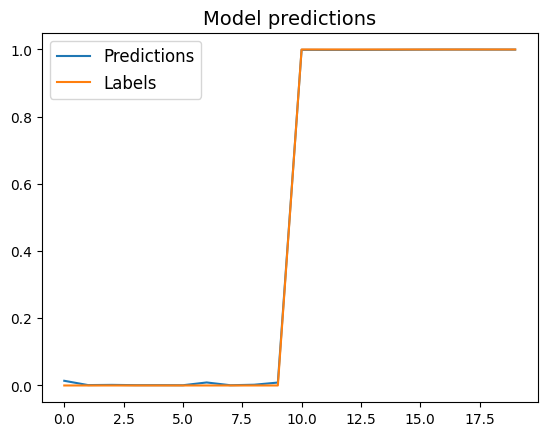

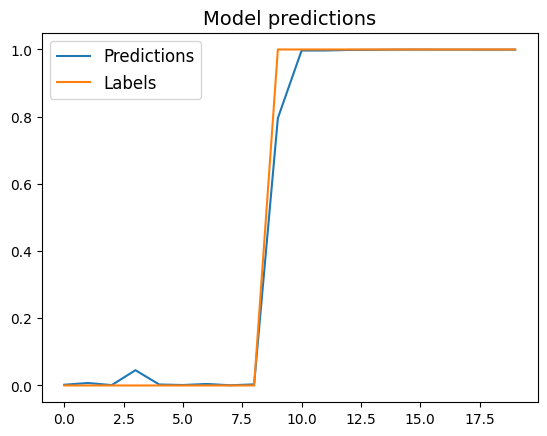

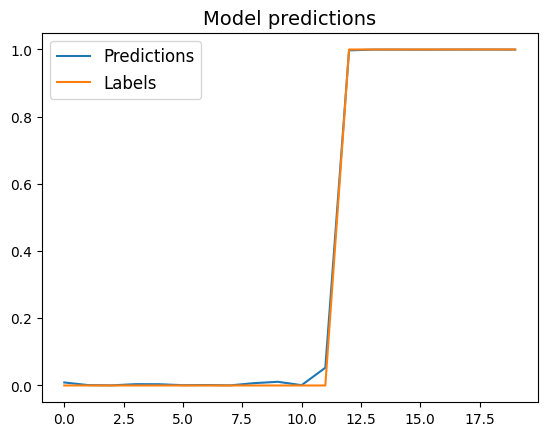

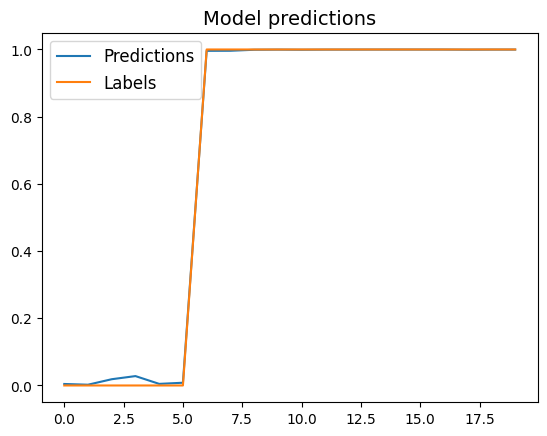

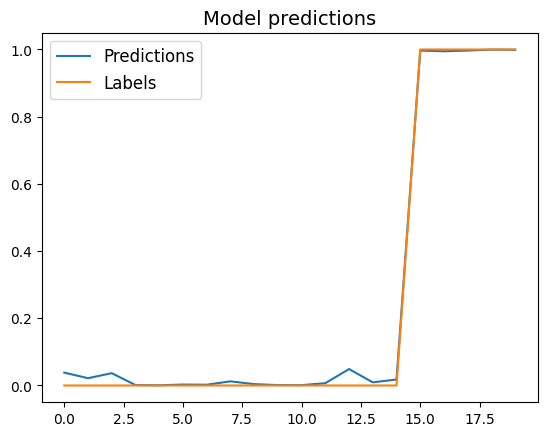

In [61]:
# use shuffled dataloader for visualization
vis_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
test_batch, test_labels = next(iter(vis_dataloader))

visualize_predictions(
    bce_model,
    model_type="seq2seq",
    sequences_batch=test_batch,
    labels_batch=test_labels,
    n_pics=10
)

#### Evaluation pipeline

To obtain final CP predictions from the model's outputs, we crop them using a pre-selected threshold $s\in(0, 1)$ and measure the main CPD metrics: Mean Detection Delay, Mean Time to False Alarm, different F1-scores (see explanation above), Covering. The threshold maximizing F1-score is considered optimal.

To evaluate the overall model's performance and determine how importaint is the choice of a threshold, we measure Area under the Detection Curve. It should be **small** and we'll see some examples later.

In [62]:
# create list of thresholds from [0, 1]
threshold_number = 50
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

_, _, delay_list_bce, fp_delay_list_bce = \
    metrics.evaluation_pipeline(bce_model,
                                bce_model.val_dataloader(),
                                threshold_list,
                                device="cpu", # choose 'cpu' or 'cuda' if available
                                model_type="seq2seq", # 'seq2seq' -- for BCE mode, 'tscp' -- for TSCP model
                                margin_list=[1, 2, 4, 6], # margins for F1-score with margin
                               )

100%|██████████| 21/21 [00:01<00:00, 18.94it/s]


AUC: 40.6696
Time to FA 11.0524, delay detection 0.1242 for best-F1 threshold: 0.6713
TN 170, FP 11, FN 10, TP 1146 for best-F1 threshold: 0.6713
Max F1 0.9909: for best-F1 threshold 0.6713
COVER 0.9932: for best-F1 threshold 0.6713
Max COVER 0.9943: for threshold 0.8742
Max F1 with margin 1: 0.9857 for best threshold 0.7903
Max F1 with margin 2: 0.9865 for best threshold 0.7903
Max F1 with margin 4: 0.9887 for best threshold 0.6249


## TS-CP2 model

TS-CP2 model is a contrastive SSL model for CPD proposed in the [paper](https://arxiv.org/abs/2011.14097) in 2021. As in all contrastive methods, the main idea is to obtain good representations of time series using an unlabelled dataset. In particular, the authors obtain representations of subsequences ('history' and 'future' windows) of the initial time series by bringing similar objects closer and dissimilar obejcts - further apart.

Positive (similar) and negative (dissimilar) pair of windows are choisen in an unsupervised way:

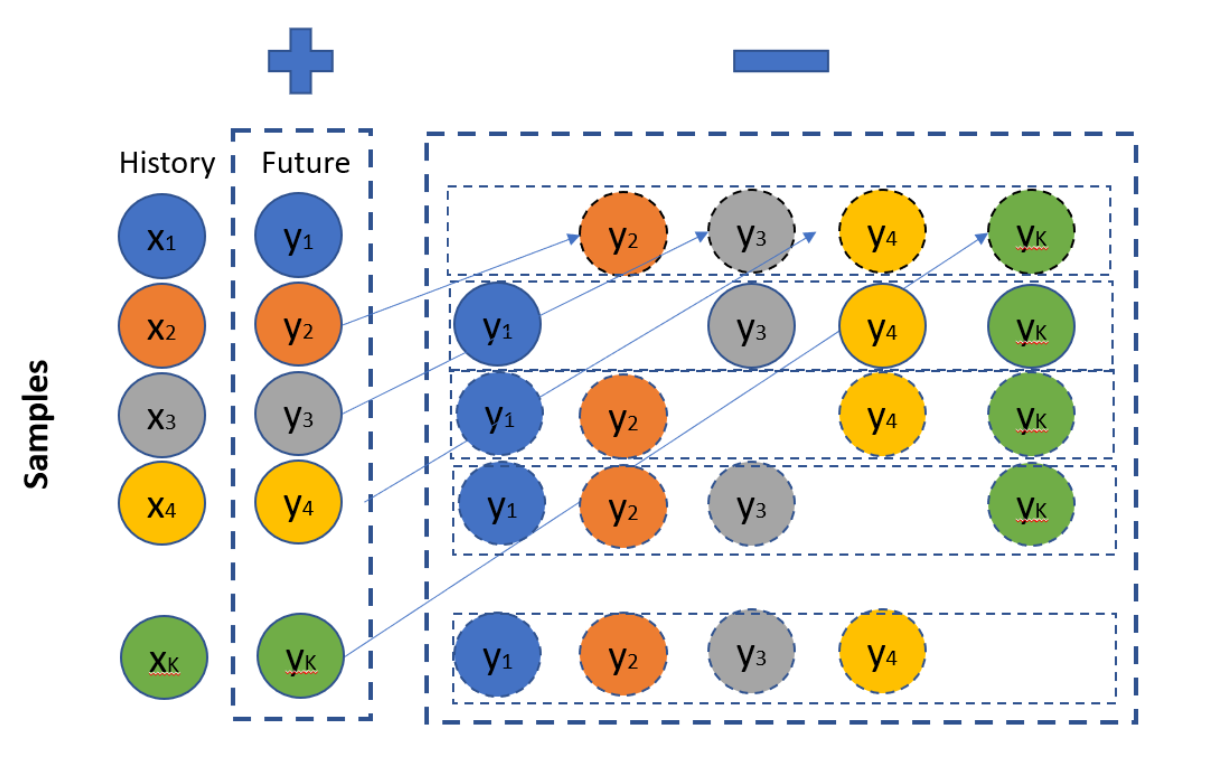

To obtain CPD predictions, we obtain embeddings of consequtive windows in a given time series amd measure cosine simiarity (or any other distance) between them:

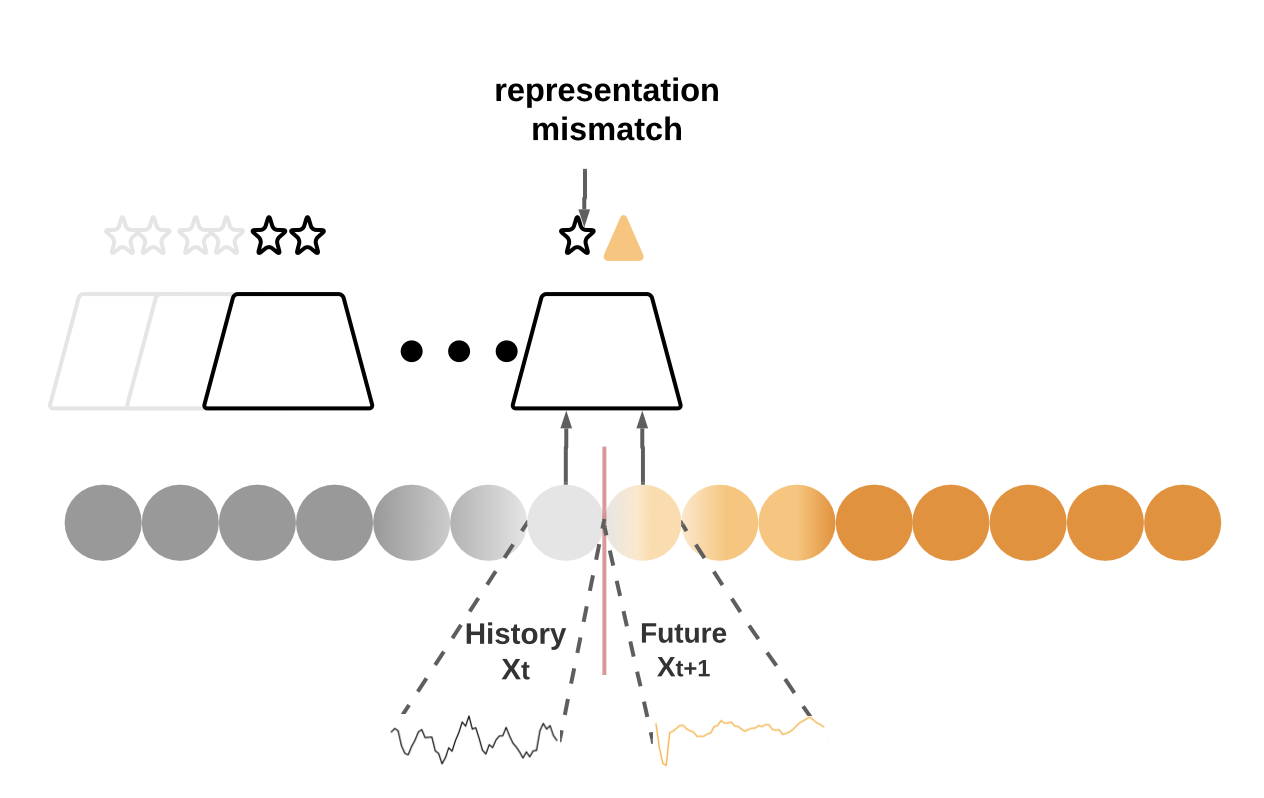

As a backbone, they use a TCN encoder that basically consists of several dilated 1D convolutional layers:

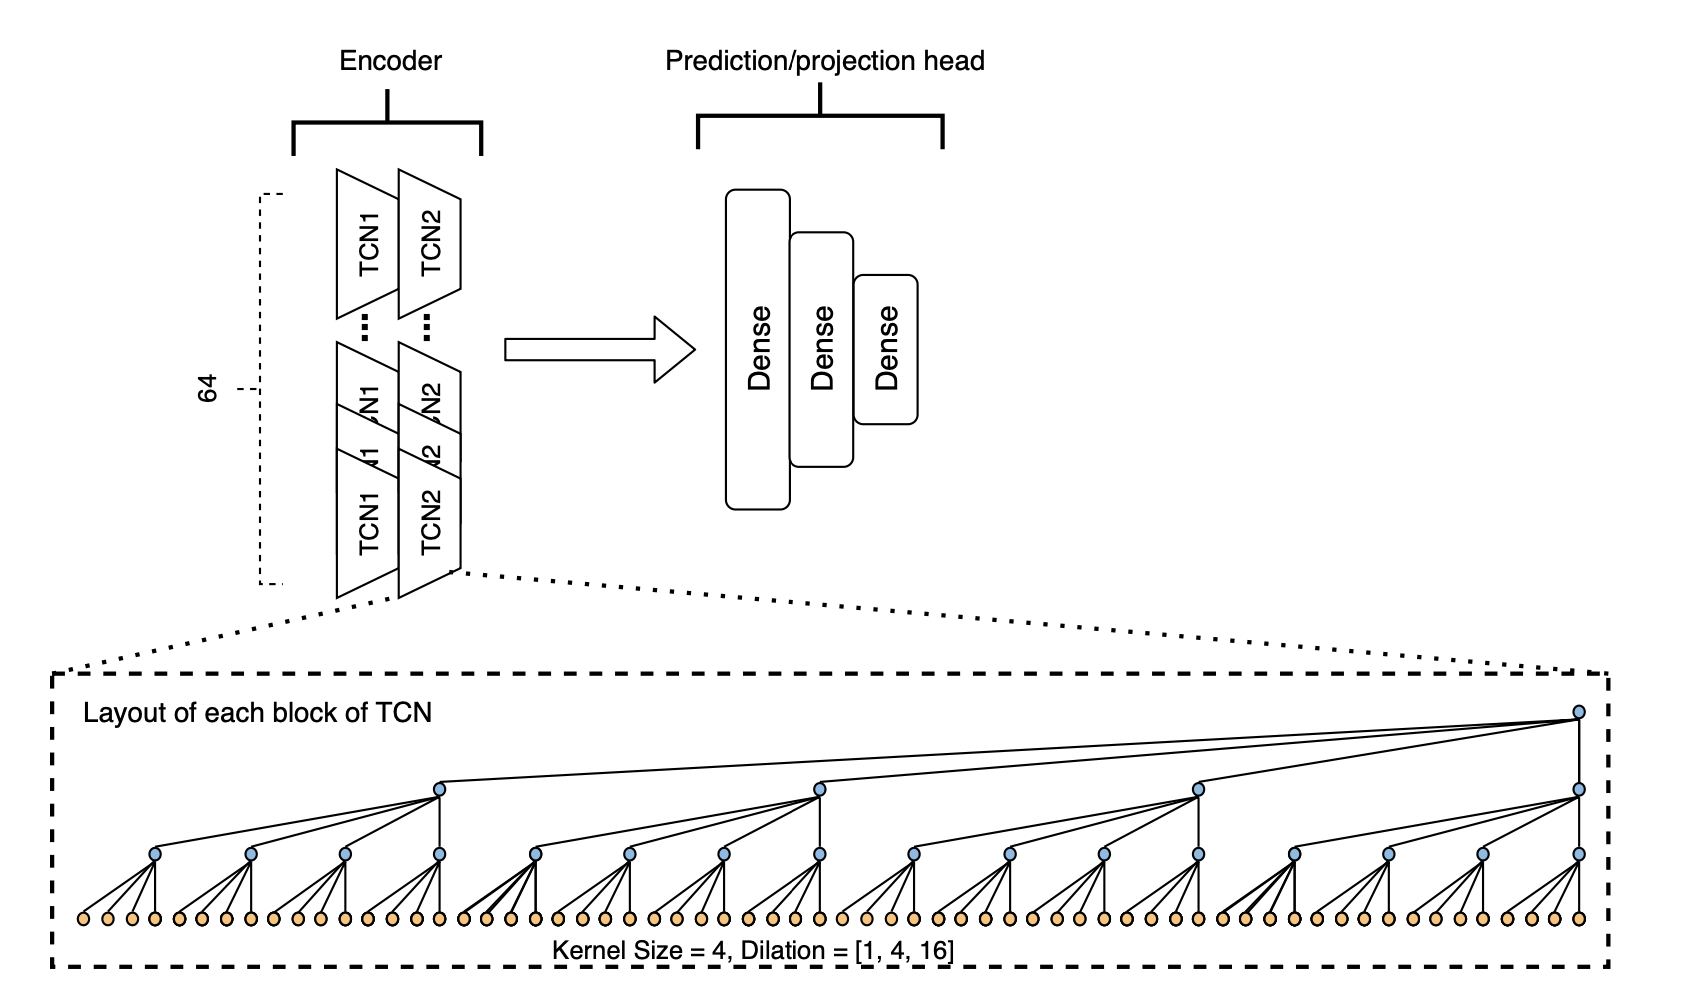

And the model is trained in a typical SSL manner with contrastive loss (similar to SimCLR):

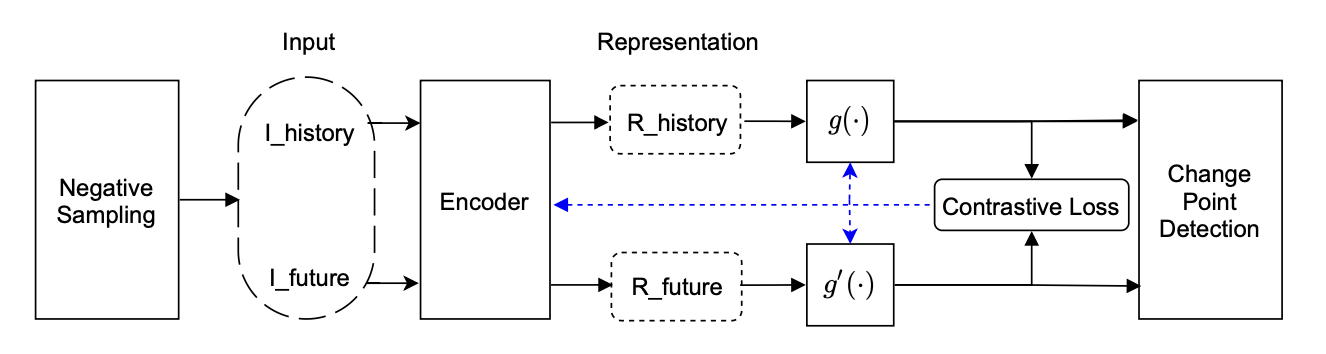

Originally, TS-CP model was implemented in tensorflow, so, we will use our PyTorch implementation which follows the same pipeline.

In [7]:
# load model's parameters from config
model_type = "tscp"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config,'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 2

In [8]:
# defive core TSCP encoder
core_model_tscp = tscp.BaseTSCPEncoder(args_config)

# define lightning CPD wrapper
tscp_model = tscp.TSCP_model(
    args_config,
    core_model_tscp,
    train_dataset,
    test_dataset
)
tscp_model

TSCP_model(
  (model): BaseTSCPEncoder(
    (tcn_layer): TCN(
      (residual_blocks): ModuleList(
        (0): ResidualBlock(
          (conv_1): Conv1d(28, 64, kernel_size=(5,), stride=(1,))
          (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (relu_1): ReLU()
          (conv_2): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
          (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (relu_2): ReLU()
          (conv_block): Sequential()
          (downsample): Conv1d(28, 64, kernel_size=(1,), stride=(1,))
          (relu): ReLU()
        )
        (1): ResidualBlock(
          (conv_1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), dilation=(2,))
          (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
# training takes a little longer (10-15 minutes) so we'll use ready-saved state dict
'''
# use logger
logger = TensorBoardLogger(save_dir="logs/")

# define trainer with custom parameters
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    # use early stopping
    callbacks=EarlyStopping(**args_config["early_stopping"])
)

trainer.fit(tscp_model)

torch.save(tscp_model.state_dict(), "saved_models/tscp_har_default.pth")
'''

In [9]:
tscp_model.load_state_dict(torch.load("saved_models/tscp_har_default.pth"))

<All keys matched successfully>

Visualization of predictions. TS-CP ouputs (cosine similarities) are post-processed by scaling and sigmoid activation for compliance with our evaluation pipeline.

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


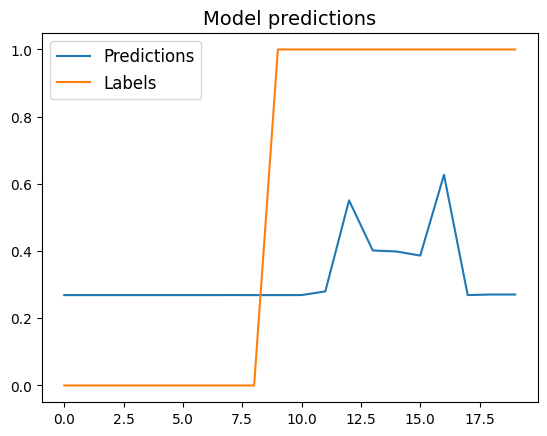

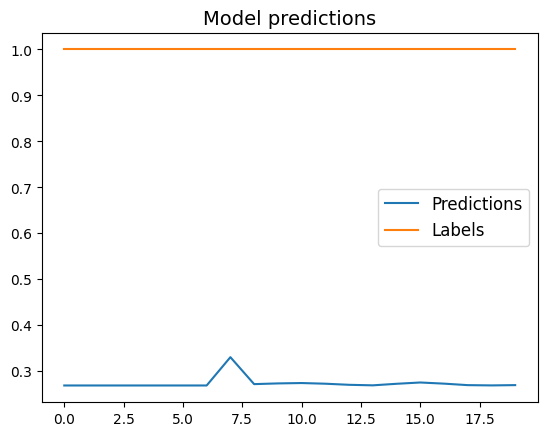

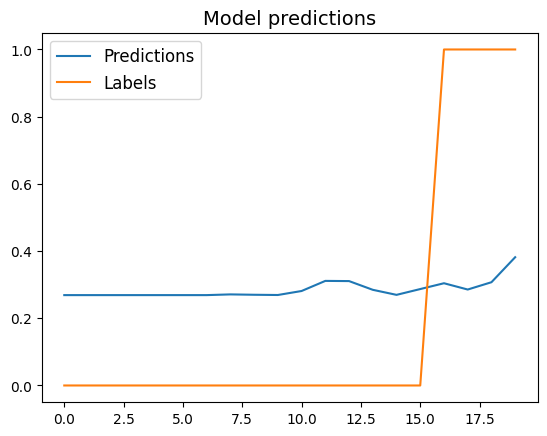

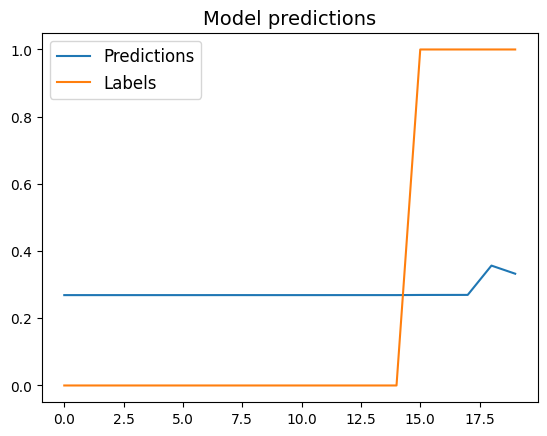

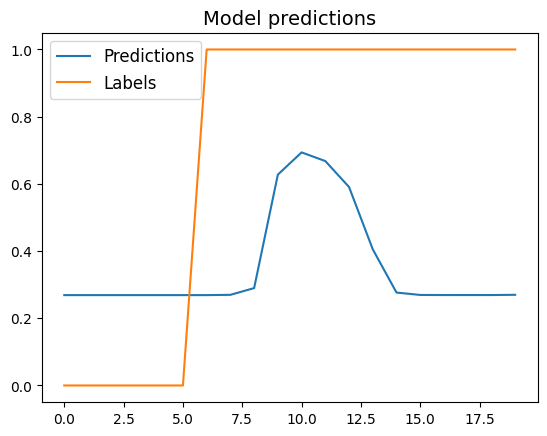

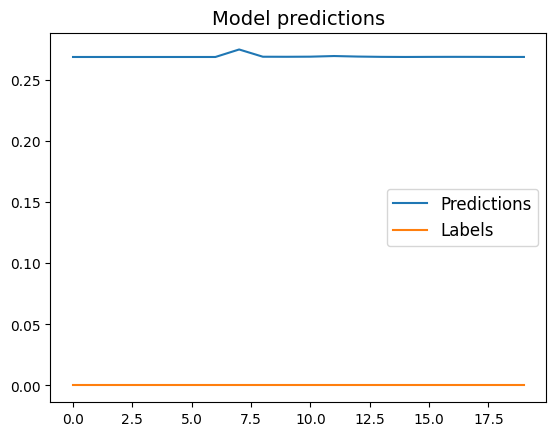

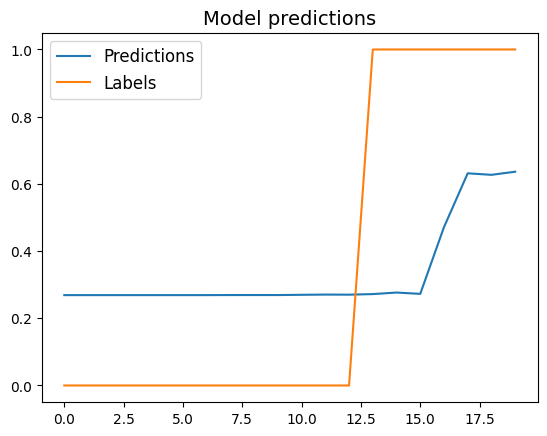

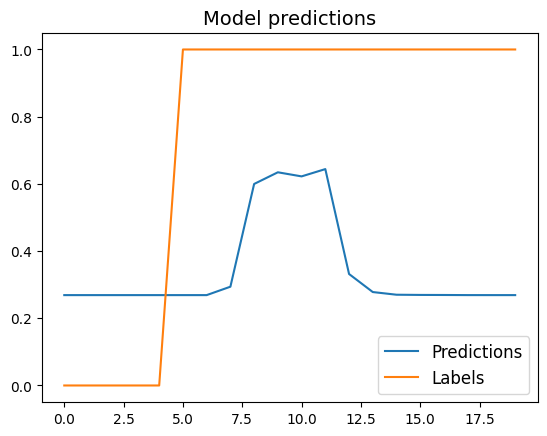

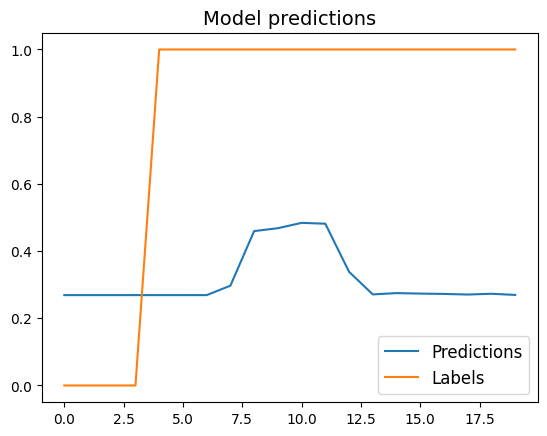

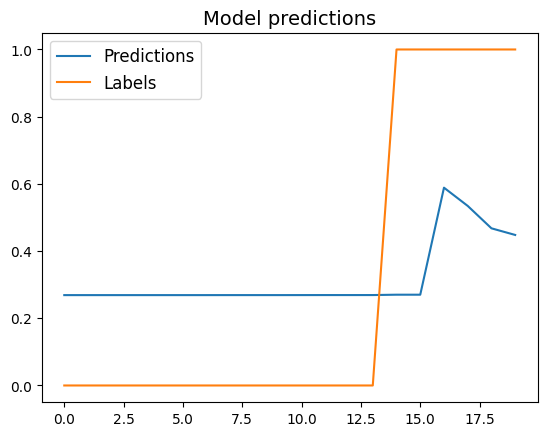

In [13]:
visualize_predictions(
    tscp_model,
    model_type="tscp",
    sequences_batch=test_batch,
    labels_batch=test_labels,
    n_pics=10,
    scale=args_config["predictions"]["scale"]
)

Evaluate model in the same way.

In [14]:
# create list of thresholds from [0, 1]
threshold_number = 50
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

_, _, delay_list_tscp, fp_delay_list_tscp = \
    metrics.evaluation_pipeline(tscp_model,
                                tscp_model.val_dataloader(),
                                threshold_list,
                                device="cpu", # choose 'cpu' or 'cuda' if available
                                model_type="tscp",
                                margin_list=[1, 2, 4, 6],
                                scale=args_config["predictions"]["scale"]
                               )

100%|██████████| 168/168 [00:21<00:00,  7.77it/s]


AUC: 68.1019
Time to FA 10.4338, delay detection 2.635 for best-F1 threshold: 0.3287
TN 155, FP 71, FN 79, TP 1032 for best-F1 threshold: 0.3287
Max F1 0.9322: for best-F1 threshold 0.3287
COVER 0.7675: for best-F1 threshold 0.3287
Max COVER 0.7831: for threshold 0.2853
Max F1 with margin 1: 0.1038 for best threshold 0.2853
Max F1 with margin 2: 0.5251 for best threshold 0.2853
Max F1 with margin 4: 0.8908 for best threshold 0.2853
Max F1 with margin 6: 0.9312 for best threshold 0.2853


#### Detection Curves

Finally, let's draw Detection Curves for the consedered models.

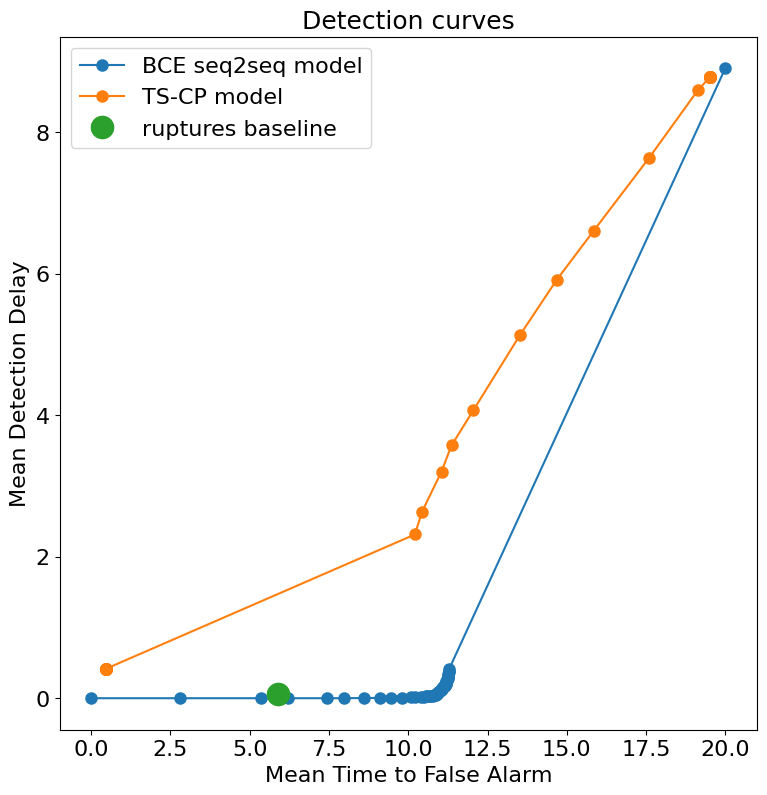

In [ ]:
plt.figure(figsize=(9, 9))
plt.plot(fp_delay_list_bce.values(), delay_list_bce.values(), '-o', markersize=8, label="BCE seq2seq model")
plt.plot(fp_delay_list_tscp.values(), delay_list_tscp.values(), '-o', markersize=8, label="TS-CP model")
plt.plot([baseline_fp_delay], [baseline_delay], 'o', markersize=16, label='ruptures baseline')
plt.title("Detection curves", fontsize=18)
plt.xlabel('Mean Time to False Alarm', fontsize=16)
plt.ylabel('Mean Detection Delay', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.show()

## Bonus part: audio segmentation with ruptures

Music segmentation can be considered as CPD task as well and quite simple ruptures models can solve it more-or-less well.

Diclaimer: this is just a demo and a small teaser of the end of the course when a couple of lectures on sound and voice analysis will be conducted. Not much details here :)

In [15]:
!pip install librosa

In [16]:
import librosa
import librosa.display

from IPython.display import Audio, display

In [17]:
def fig_ax(figsize=(15, 5), dpi=150):
    """Return a (matplotlib) figure and ax objects with given size."""
    return plt.subplots(figsize=figsize, dpi=dpi)

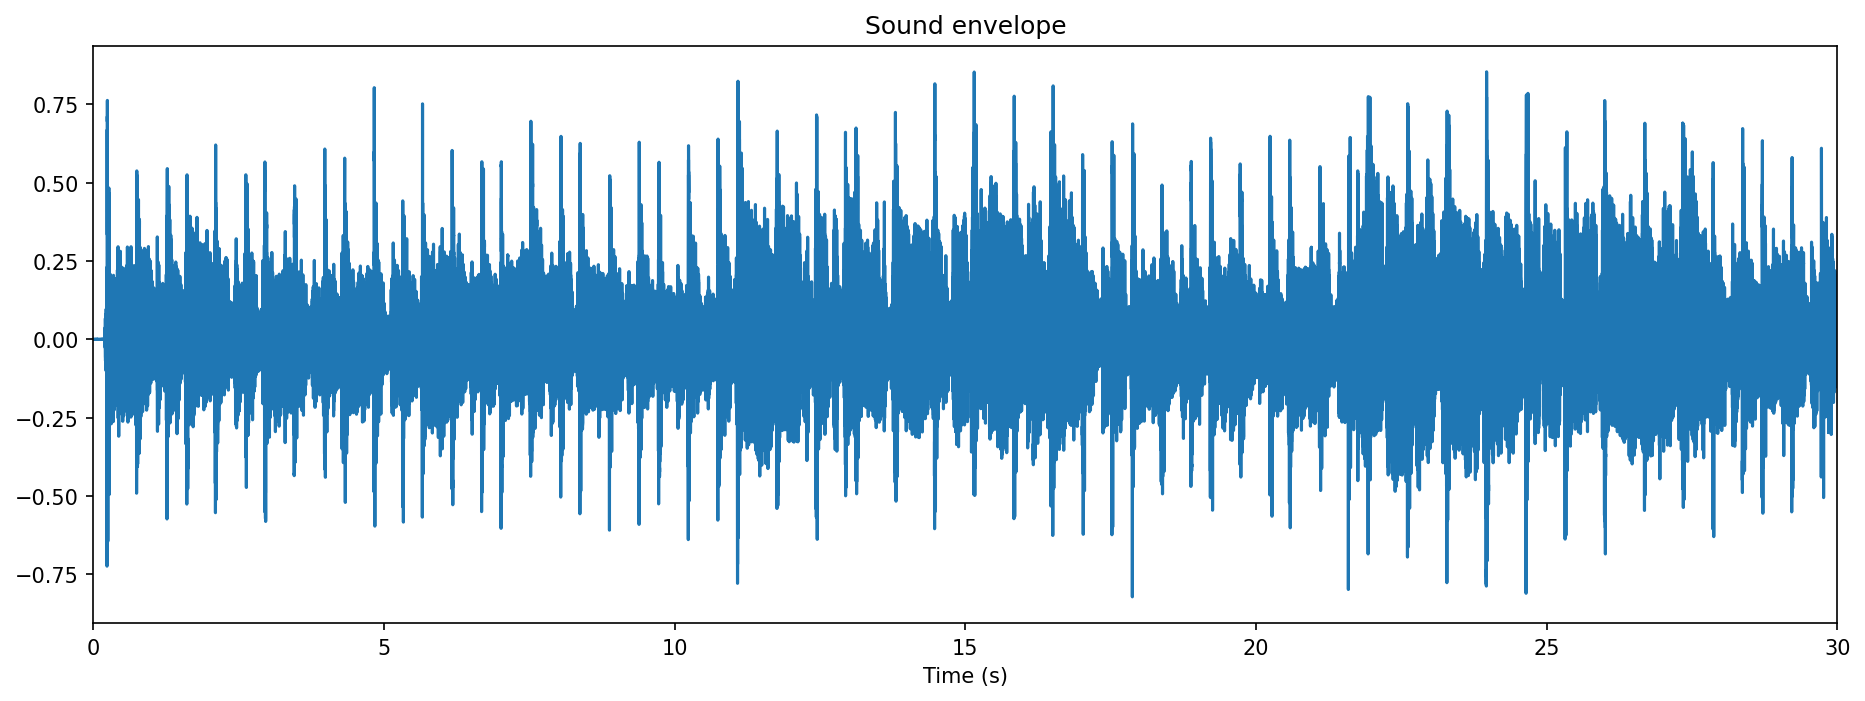

In [18]:
duration = 30  # in seconds
signal, sampling_rate = librosa.load(librosa.ex("fishin"), duration=duration)

# listen to the music
display(Audio(data=signal, rate=sampling_rate))

# look at the envelope
fig, ax = fig_ax()
ax.plot(np.arange(signal.size) / sampling_rate, signal)
ax.set_xlim(0, signal.size / sampling_rate)
ax.set_xlabel("Time (s)")
_ = ax.set(title="Sound envelope")

In [19]:
signal.shape

(661500,)

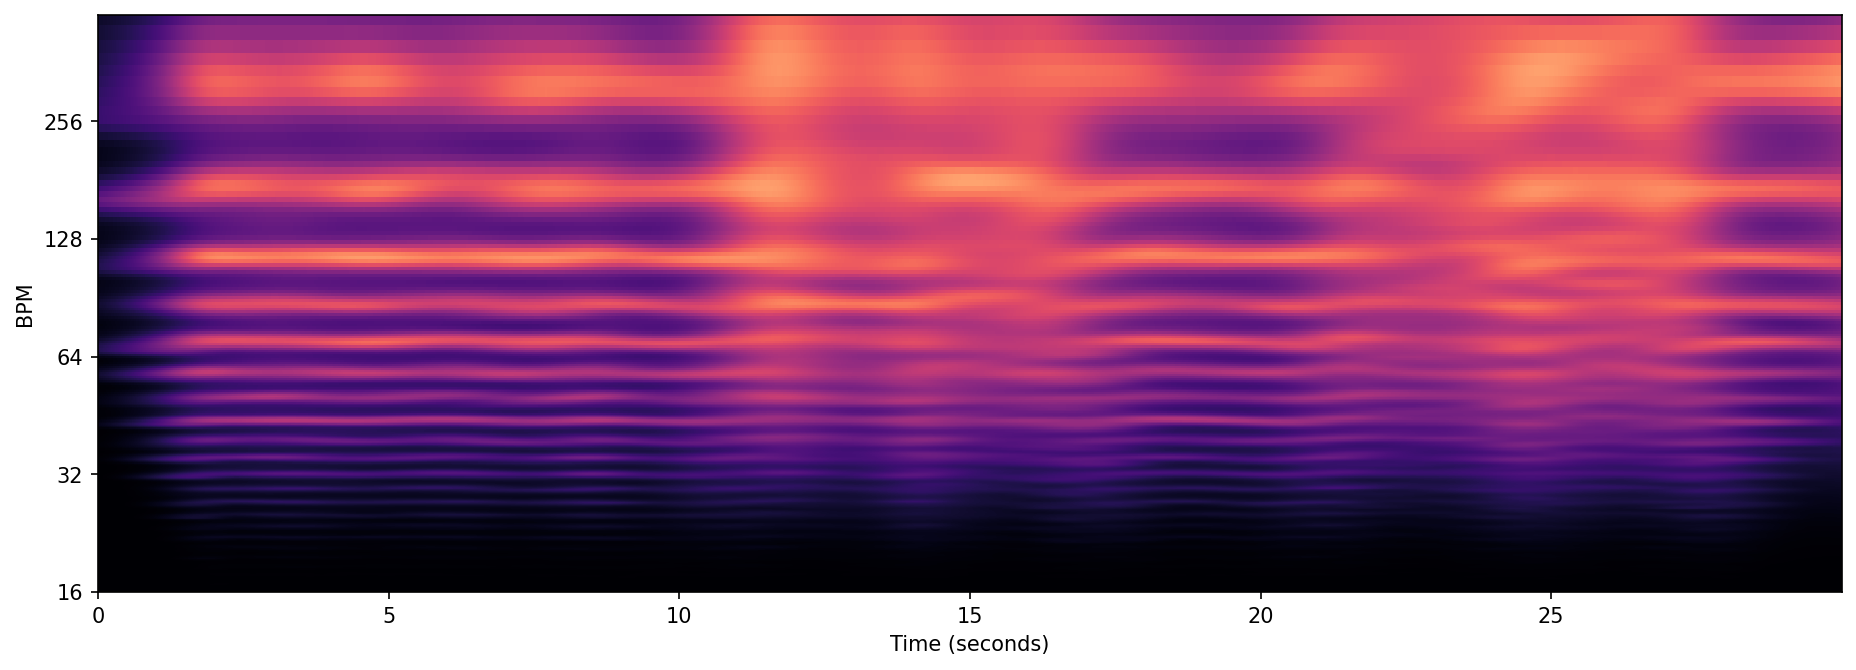

In [20]:
# Compute the onset strength
hop_length_tempo = 256
oenv = librosa.onset.onset_strength(
    y=signal, sr=sampling_rate, hop_length=hop_length_tempo
)
# Compute the tempogram - a time-tempo representation that encodes the local tempo of a music signal over time
tempogram = librosa.feature.tempogram(
    onset_envelope=oenv,
    sr=sampling_rate,
    hop_length=hop_length_tempo,
)

# Display the tempogram
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    hop_length=hop_length_tempo,
    sr=sampling_rate,
    x_axis="s",
    y_axis="tempo",
)

In [23]:
tempogram.T.shape

(2584, 384)

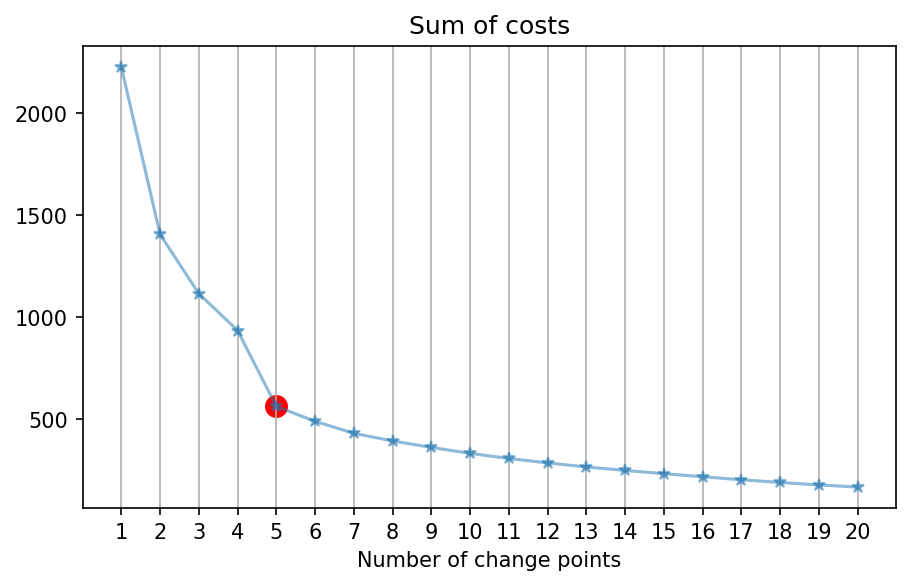

In [24]:
# Choose detection method
algo = rpt.KernelCPD(kernel="linear").fit(tempogram.T)

# Choose the number of changes (elbow heuristic)
n_bkps_max = 20  # K_max
# Start by computing the segmentation with most changes.
# After start, all segmentations with 1, 2,..., K_max-1 changes are also available for free.
_ = algo.predict(n_bkps_max)

array_of_n_bkps = np.arange(1, n_bkps_max + 1)

def get_sum_of_cost(algo, n_bkps) -> float:
    """Return the sum of costs for the change points `bkps`"""
    bkps = algo.predict(n_bkps=n_bkps)
    return algo.cost.sum_of_costs(bkps)

fig, ax = fig_ax((7, 4))
ax.plot(
    array_of_n_bkps,
    [get_sum_of_cost(algo=algo, n_bkps=n_bkps) for n_bkps in array_of_n_bkps],
    "-*",
    alpha=0.5,
)
ax.set_xticks(array_of_n_bkps)
ax.set_xlabel("Number of change points")
ax.set_title("Sum of costs")
ax.grid(axis="x")
ax.set_xlim(0, n_bkps_max + 1)

# Visually we choose n_bkps=5 (highlighted in red on the elbow plot)
n_bkps = 6
_ = ax.scatter([5], [get_sum_of_cost(algo=algo, n_bkps=5)], color="r", s=100)


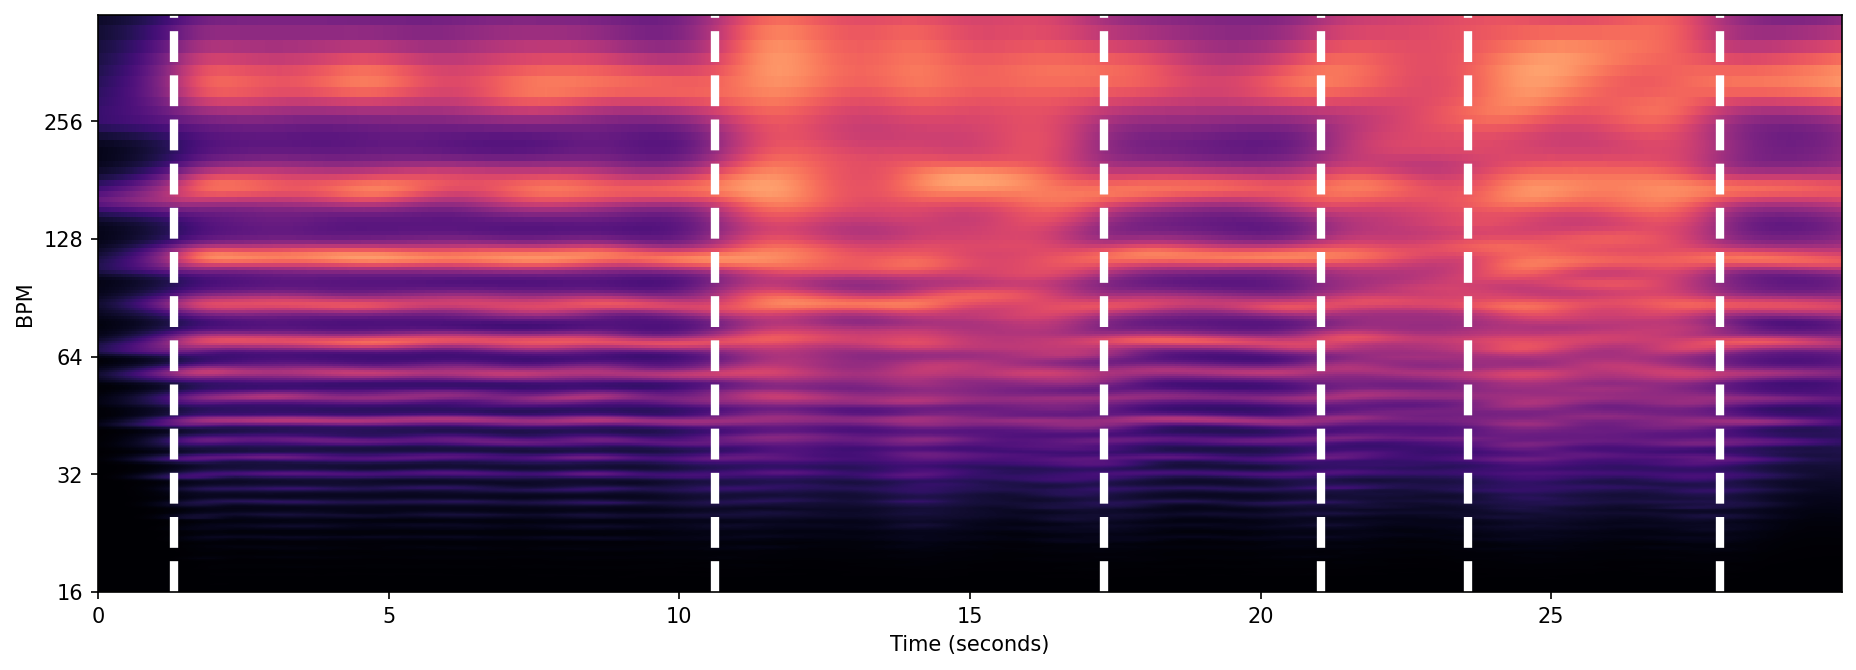

In [25]:
# Segmentation
bkps = algo.predict(n_bkps=n_bkps)
# Convert the estimated change points (frame counts) to actual timestamps
bkps_times = librosa.frames_to_time(bkps, sr=sampling_rate, hop_length=hop_length_tempo)

# Displaying results
fig, ax = fig_ax()
_ = librosa.display.specshow(
    tempogram,
    ax=ax,
    x_axis="s",
    y_axis="tempo",
    hop_length=hop_length_tempo,
    sr=sampling_rate,
)

for b in bkps_times[:-1]:
    ax.axvline(b, ls="--", color="white", lw=4)


In [26]:
# Compute change points corresponding indexes in original signal
bkps_time_indexes = (sampling_rate * bkps_times).astype(int).tolist()

for (segment_number, (start, end)) in enumerate(
    rpt.utils.pairwise([0] + bkps_time_indexes), start=1
):
    segment = signal[start:end]
    print(f"Segment n°{segment_number} (duration: {segment.size/sampling_rate:.2f} s)")
    display(Audio(data=segment, rate=sampling_rate))


Segment n°1 (duration: 1.30 s)


Segment n°2 (duration: 9.31 s)


Segment n°3 (duration: 6.70 s)


Segment n°4 (duration: 3.73 s)


Segment n°5 (duration: 2.53 s)


Segment n°6 (duration: 4.33 s)


Segment n°7 (duration: 2.10 s)
